# Initialize the Project

##### Create a project and define result and input directories
 - For demo purposes, choose project names and genelist inputs from the list below
 - gene list input files are stored in the INPUT_DIR

In [1]:

import os.path as op

ProjectName = 'QSPACE-24_example'
demo = True  # set this to True to bypass the OPM server and Alphafold Multimer calculations ONLY for QS-24
geneListInput = '000A-gene_list_example24.txt' #Example run 

# ProjectName = 'QSPACE-1515'
# geneListInput = '000A-gene_list_iML1515.txt' # iML1515
# demo  = False

# ProjectName = 'QSPACE-GS'
# geneListInput = '000A-gene_list_4349.txt' # Genome-Scale
# demo  = False

# force_rerun_global = True  # best to set to False, this will force re-downloads, re-alignment etc.
force_rerun_global = False  #this is run #2  < use this to avoid re-downloading seq/struct files

ROOT_DIR = '/home/ecatoiu/Projects/QSPACE_install/QSPACE/' 
EXTERNAL_HARDDRIVE_DIR =  '../../../../../../../mnt/wwn-0x5000c500b96b98e1-part1/QSPACE_install/' #downloaded structures, membrane data etc.
INPUT_DIR = op.join(ROOT_DIR, 'Manuscript/Inputs/')  #leave as is to run QS-24 example / QS-1515 / QS-GS


##### FOR DEMO PURPOSES:
- we set the results directory inside the root directory
- usually this should be set outside the root directory

In [2]:
RESULTS_DIR = '/home/ecatoiu/Projects/QSPACE_install/Demo_Results/'  #QSPACE-generated result data and figures

##### Define paths used for various modules
- path_to_swissRepositoryFolder &emsp; --> Module 001B
- path_to_chromedriver &emsp;&emsp;&emsp;&emsp;&emsp;&nbsp; --> Module 005C
- path_to_scratch &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;--> Module 006B

<b>SWISS model repository</b> : https://swissmodel.expasy.org/repository

<b>Chromedriver</b> : https://chromedriver.chromium.org/downloads

<b>SCRATCH</b> : https://scratch.proteomics.ics.uci.edu/

In [3]:
#SWISS-PROT homology models repository
path_to_swissRepositoryFolder = '../../../../../mnt/wwn-0x5000c500b96b98e1-part1/QSPACE_ecoli/inputs/SWISS-MODEL_Repository/'
path_to_chromedriver = '/home/ecatoiu/Projects/chromedriver' 
path_to_scratch ='/usr/bin/scratch/SCRATCH-1D_1.1/bin/run_SCRATCH-1D_predictors.sh'


# Initialize the Project Directories

In [4]:
# Import the qspace class
from qspace import QSPACE

qspace = QSPACE(ProjectName=ProjectName, 
                root_dir=ROOT_DIR, 
                external_hardDrive_dir=EXTERNAL_HARDDRIVE_DIR,
                results_dir=RESULTS_DIR,
                input_dir=INPUT_DIR,
               demo = True)#, ssbio_dir = SSBIO_DIR)

import time
time_module_start = time.time()
time_block_start = time.time()
time_global_start = time.time()
import math

def get_computation_time(label, time_start):
    
    
    minutes = math.floor((time.time() - time_start) / 60.)
    seconds = (time.time() - time_start) % 60.
    print ("{} :  {:.1f}m  {:.1f}s".format(label, minutes, seconds))
    return time.time() - time_start
    
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import pandas as pd
import os.path as op
import os
from importlib import reload
import json
import ast
import copy
import time
from tqdm import tqdm_notebook as tqdm
import numpy as np
import sys
sys.path.append('../')

#import qspace functions
sys.path.append(qspace.FunctionsDir)
from functions import prepare_structures_for_BFS as prepBFS
from functions import  oligomerization
from functions import  bfs_algo
from functions import  pseudo_structures as pseudo
from functions import  read_uniprot_text

import _sequenceModule as sequenceModule
import _homologyModule as homologyModule
import _pdbModule as pdbModule
import _figuresModule as figuresModule
import _proteinTargetAnnotationModule as pTAM
import _proteinToStructuresModule as pTSM
import _membraneModule as membraneModule
import _structuralPropertiesModule as structuralPropertiesModule
import _mutantFunctionModule as mutantFunctionModule
import _compileDataModule as compileDataModule

from _structuralPropertiesModule import utils as structuralPropUtils

runTimeFile = op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global))
if op.exists(runTimeFile):
    with open (runTimeFile,'r' ) as f:
        comp_time_data = json.load(f)
else:
    comp_time_data = {}

/usr/local/lib/python3.7/dist-packages/Bio/pairwise2.py:283: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  BiopythonDeprecationWarning,


In [5]:
#confirm demo folders are being used if desired
print (qspace.alphafoldMultimerDir)
print (qspace.opmOutputStructuresDir)

/home/ecatoiu/Projects/QSPACE_install/QSPACE/Demo_Results/AFMstructures
/home/ecatoiu/Projects/QSPACE_install/QSPACE/Demo_Results/fromOPMstructures


In [6]:
! python --version

Python 3.7.9


# Sequence Module (#000A-C)

- <b>#000A</b> --  Determine UniProt IDs for a list of genes
- <b>#000B</b> --  Download UniProt Sequences (.txt and .fasta)
- <b>#000C</b> --  Download Alleleome Sequences (.fasta)


In [7]:
#computation time
time_module_start = time.time()

##### Blattner - UniProt Mapping  ( #000A )

For your own project, upload your list of genes to https://www.uniprot.org/id-mapping. Download your web results  in the appropriate folder (RESULTS_DIR + 'data' + ProjectName).  For E. coli, we map a list of BLATTNER numbers to UniProt IDs using the "Ensembl Genomes" option.  

In [8]:
time_block_start = time.time()

my_uniprot_web_query_file =  '000A-uniprot_ids_from_websearch.xlsx'

blattnerUniprotMapping, qspacegeneList = sequenceModule.run_000A(geneListInput = geneListInput, #initialized at start
                                                           UniprotQueryInput =my_uniprot_web_query_file,
                                                           manual_correction = True,
                                                           trim = True,
                                                          )


#keep track of the compute time
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '000A', time_start=time_block_start)
comp_time_data.update({'0A' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Determining UniProt IDs from a list of Genes...
-------------------------------------------------------------
INFO:_sequenceModule._000A_BlattnerToUniprot:Gene list input file :
	/home/ecatoiu/Projects/QSPACE_install/QSPACE/Manuscript/Inputs/000A-gene_list_example24.txt
INFO:_sequenceModule._000A_BlattnerToUniprot:Uniprot query input file :
	/home/ecatoiu/Projects/QSPACE_install/QSPACE/Manuscript/Inputs/000A-uniprot_ids_from_websearch.xlsx
INFO:_sequenceModule._000A_BlattnerToUniprot:Using manual UniprotID mapping
INFO:_sequenceModule._000A_BlattnerToUniprot:Found UniProt IDs for 24 genes
INFO:_sequenceModule._000A_BlattnerToUniprot:Saving Blattner-Uniprot mapping :
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/000A-uniprot_blattner_mapping.json
INFO:_sequenceModule._000A_BlattnerToUniprot:Saving Blattner-Uniprot mapping :
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/000A-blattner_to_uniprot_mapping.csv

Computation Time
------

##### Download UniProt Sequences  ( #000B )

Downloads the .txt and .fasta files for your queried UniProt Ids into the directory :  qspace.UniprotSeqsDir

In [9]:
time_block_start = time.time()
sequenceModule.run_000B(blattnerUniprotMapping=blattnerUniprotMapping,
                    force_rerun = False)
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '000B', time_start=time_block_start)
comp_time_data.update({'0B' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

----------------------------------------------------
INFO:_sequenceModule._000B_DownloadUniprotFiles:Saving files to :
	../../../../../../../mnt/wwn-0x5000c500b96b98e1-part1/QSPACE_install/sequences/uniprot


A Jupyter Widget



Computation Time
--------------------------
000B :  0.0m  0.0s


##### Download [WT Alleleome](https://www.pnas.org/doi/10.1073/pnas.2218835120) Sequences  for E. coli ( #000C )


Alleleomes are available for E. coli at https://github.com/EdwardCatoiu/Alleleome. 

if using Alleleome_Data/dfz (recommended)
- clone the github repository
- set path to the Alleleome_Data/dfz folder

if not using E. coli, skip the next step

In [10]:
time_block_start = time.time()
#set your alleleone data input folder
alleleomeInputFolder='../../../../../mnt/wwn-0x5000c500b96b98e1-part1/Alleleome_PNAS/Alleleome_Data/dfz'
sequenceModule.run_000C(alleleomeInputFolder=alleleomeInputFolder, 
                        geneListInput = geneListInput,
                        force_rerun = False

                       )
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '000C', time_start=time_block_start)
comp_time_data.update({'0C' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

-------------------------------------------------------------
INFO:_sequenceModule._000C_DownloadWtAlleleomeSeqs:Gene list input file :
	/home/ecatoiu/Projects/QSPACE_install/QSPACE/Manuscript/Inputs/000A-gene_list_example24.txt
INFO:_sequenceModule._000C_DownloadWtAlleleomeSeqs:Alleleome Data location :
	../../../../../mnt/wwn-0x5000c500b96b98e1-part1/Alleleome_PNAS/Alleleome_Data/dfz

Moving Files...


A Jupyter Widget


INFO:_sequenceModule._000C_DownloadWtAlleleomeSeqs:Alleleome Seqs Downloaded for 24 Genes

Computation Time
--------------------------
000C :  0.0m  0.0s


In [11]:
print( '\nComputation Time\n--------------------------')
get_computation_time(label = 'Sequence Module', time_start=time_module_start)



Computation Time
--------------------------
Sequence Module :  0.0m  1.0s


1.0266005992889404

# Homology Module (#001A-C)

- <b>#001A</b> --  Download Alphafold models, assess quality
- <b>#001B</b> --  Download SWISS-models, assess quality
- <b>#001C</b> --  Download ITASSER models, assess quality
- <b>#001D</b> --  Sequence alignment of UniProt/WT sequences to all models 

In [12]:
#computation time
time_module_start = time.time()

##### Alphafold DB  ( #001A )

Downloads the Alphafold model and quality metrics for each uniprot ID (e.g. from https://alphafold.ebi.ac.uk/entry/P46133).

In [13]:
time_block_start = time.time()
dfalphafold_monomer = homologyModule.run_001A(blattnerUniprotMapping=blattnerUniprotMapping,
                                              force_redownload= False,
                                              force_realign= force_rerun_global,
                                              alphafoldStructuresDir= False,
                                              alphafoldMetricsDir= False
                                             )
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '001A', time_start=time_block_start)
comp_time_data.update({'1A' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

----------------------------------------------------------


A Jupyter Widget


Checking Quality of Alphafold Structure Database Models...
--------------------------------------------


A Jupyter Widget


INFO:_homologyModule._001A_AlphafoldModels:Saving Quality of Alphafold Monomers... 
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001A-quality_of_alphafold_monomers.json
INFO:_homologyModule._001A_AlphafoldModels:Saving Quality of Alphafold Monomers... 
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001A-quality_of_alphafold_monomers.csv


A Jupyter Widget


Finding missing needle alignments ...
--------------------------------------


A Jupyter Widget


INFO:_homologyModule.utils:Saving Missing Needle Alignments...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001A-expected_alignment_files_ALPHAFOLD.json

Computation Time
--------------------------
001A :  0.0m  2.5s


##### SWISS MODEL ( #001B )

Your "path_to_swissRepositoryFolder" is initialized at the beginning of this notebook.
Download the organism-specific SWISS-PROT repository at https://swissmodel.expasy.org/repository

In [14]:
time_block_start = time.time()

homologyModule.run_001B(blattnerUniprotMapping =blattnerUniprotMapping,
                        swissRepositoryFolder = path_to_swissRepositoryFolder,
                        force_realign= force_rerun_global,
                    )
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '001B', time_start=time_block_start)
comp_time_data.update({'1B' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)
  
from ssbio.databases.swissmodel import get_oligomeric_state  
swiss_model_metrics = {}
for f in os.listdir(qspace.swissStructuresDir):
    fp = op.join(qspace.swissStructuresDir, f)
    model_metrics = get_oligomeric_state(fp)
    model_metrics_to_save = {}
    for metric in ['QSPRD','GMQE','QMN4']:
        if metric in model_metrics:
            model_metrics_to_save.update({metric : float(model_metrics[metric])})
    swiss_model_metrics.update({f.split('.')[0] : model_metrics_to_save})
    
outfile= op.join(qspace.DataOutput_dir, '001B-swiss_model_metrics.json') 
with open(outfile,'w') as f:
    json.dump(swiss_model_metrics,f)

Moving SWISS Models from the repository into...
------------------------------------------------
	> ../../../../../../../mnt/wwn-0x5000c500b96b98e1-part1/QSPACE_install/structures/all_swiss


A Jupyter Widget


Finding all real protein chains in SWISS MODELS...
-----------------------------------


A Jupyter Widget


INFO:_homologyModule._001B_SwissModels:Saving SWISS-chain-gene maps ... 
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001B-SWISS-model_chains_to_genes.json
Finding missing needle alignments ...
--------------------------------------


A Jupyter Widget


INFO:_homologyModule.utils:Saving Missing Needle Alignments...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001B-expected_alignment_files_SWISS.json

Computation Time
--------------------------
001B :  0.0m  4.1s


##### I-TASSER  ( #001C )

For E.coli, download the ITASSER-model repository from https://zhanggroup.org/QUARK/ecoli/ and https://zhanggroup.org/QUARK/ecoli2/. We the webscraped the TM-score metadata and data tables on these sites and provide it as "001C-ITASSER_raw_metadata_hyperlink_tmscores.csv".

In [15]:

infile = op.join(qspace.Input_dir, '001C-ITASSER_raw_metadata_hyperlink.csv')
infile_wScores = op.join(qspace.DataOutput_dir, '001C-ITASSER_raw_metadata_hyperlink_tmscores.csv')
if op.exists(infile_wScores):
    itasser_metadata = pd.read_csv(infile_wScores, index_col=0)
    needs_scoring = False
else:
    itasser_metadata = pd.read_csv(infile, index_col=0)
    needs_scoring = True
  

itasser_metadata = itasser_metadata[itasser_metadata.index.isin(blattnerUniprotMapping.values())]   
itasserRepoFolder = '../../../../../../../../mnt/wwn-0x5000c500b96b98e1-part1/QSPACE_ecoli/inputs/ITASSER-MODEL-Repository/'
needs_scoring

False

Clean the itasser models and remove string-like region

In [16]:
time_block_start = time.time()
df_itasser_outliers = homologyModule.run_001C(itasser_metadata = itasser_metadata,
                                              itasserRepoFolder = itasserRepoFolder, 
                                              blattnerUniprotMapping = blattnerUniprotMapping,
                                              needs_scoring = needs_scoring,
                                              force_clean  = True, #True when using for first time
                                              force_realign = True,#True when using for first time
                                              force_remove_string = True, #True when using for first time
#                                               save_outliers = True,#True when using
                    )
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '001C', time_start=time_block_start)
comp_time_data.update({'1C' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget


Cleaning ITASSER MODELS...
----------------------------------


A Jupyter Widget


Removing string-like regions from ITASSER MODELS...
---------------------------------


A Jupyter Widget

A Jupyter Widget


INFO:_homologyModule._001C_ItasserModels:Saving String-like regions of ITASSER models... 
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001C-ITASSER-stringOutliers.csv
Getting total chains in ITASSER files....
----------------------------------


A Jupyter Widget


INFO:_homologyModule._001C_ItasserModels:Saving gene-chain maps for ITASSER models... 
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001C-ITASSER-model_chains_to_genes.json
Finding missing needle alignments ...
--------------------------------------


A Jupyter Widget


INFO:_homologyModule.utils:Saving Missing Needle Alignments...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001C-expected_alignment_files_ITASSER.json

Computation Time
--------------------------
001C :  0.0m  9.7s


##### Alignment ( #001D )

Align the homology models chains to the reference gene sequences.  If not using a set of homology models, set them to <b>False</b> below:

In [17]:
used_itasser = True  
used_alphafold = True
used_swiss = True

In [18]:
time_block_start = time.time()
dfseq = homologyModule.run_001D(genelist = qspacegeneList, 
                                blattnerUniprotMapping = blattnerUniprotMapping,
                                force_rerun = force_rerun_global,
                                itasser = used_itasser, 
                                alphafold = used_alphafold,
                                swiss = used_swiss,
                                itasser_metadata = itasser_metadata)

print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '001D', time_start=time_block_start)
comp_time_data.update({'1D' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)
dfseq.head()

Getting gene sequences from Uniprot and Alleleome...
---------------------------------------------


A Jupyter Widget


INFO:_homologyModule._001D_HomologyAlign:Saving DataFrame of gene sequences ... 
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001D-dfrepseq.csv
Aligning SWISS-PROT models to Uniprot Sequences...
------------------------------------------------------------


A Jupyter Widget

A Jupyter Widget


INFO:_homologyModule._001D_HomologyAlign:Saving SWISS-PROT model quality ... 
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001D-quality_of_swiss_models.json
Aligning I-TASSER models to Uniprot Sequences...
------------------------------------------------------------


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


INFO:_homologyModule._001D_HomologyAlign:Saving ITASSER model quality ... 
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/001D-quality_of_itasser_models.json
Aligning AlphaFold models to Uniprot Sequences...
------------------------------------------------------------


A Jupyter Widget



Computation Time
--------------------------
001D :  0.0m  1.3s


,UniProtId,UniProtSeq,UniProtSeqLen,AlleleomeId,AlleleomeSeq,AlleleomeSeqLen
b2336,P77599,MSDLLCSAKLGAMTLALLLSATSLSALASVTPDRTRLIFNESDKSI...,250.0,b2336_WT_consensus,MSDLLCSAKLGAMTLALLLSATSLSALASVTPDRTRLIFNESDKSI...,250.0
b0463,P0AE06,MNKNRGFTPLAVVLMLSGSLALTGCDDKQAQQGGQQMPAVGVVTVK...,397.0,b0463_WT_consensus,MNKNRGFTPLAVVLMLSGSLALTGCDDKQAQQGGQQMPAVGVVTVK...,397.0
b3241,P46482,MKTLIRKFSRTAITVVLVILAFIAIFNAWVYYTESPWTRDARFSAD...,310.0,b3241_WT_consensus,MKTLIRKFSRTAITVVLVILAFIAIFNAWVYYTESPWTRDARFSAD...,310.0
b3240,P46481,MGIFSIANQHIRFAVKLATAIVLALFVGFHFQLETPRWAVLTAAIV...,655.0,b3240_WT_consensus,MGIFSIANQHIRFAVKLATAIVLALFVGFHFQLETPRWAVLTAAIV...,655.0
b1221,P0AF28,MSNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIE...,216.0,b1221_WT_consensus,MSNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIE...,216.0


#### Pseudo-structure Homology ( # 001E)

Generate pseudo-structures from homology models. A pseudo-structure is a unique combination of genes that can re-create the gene-stoichiometry of the structure file.

In [19]:
time_block_start = time.time()

if used_swiss:
    ####SWISS MODELS
    swiss_model_metrics = op.join(path_to_swissRepositoryFolder ,'INDEX')
    dfswiss_model_metrics = pd.read_csv(swiss_model_metrics, skiprows=6, sep ='\t')

    with open(op.join(qspace.DataOutput_dir, '001D-quality_of_swiss_models.json'), 'rb') as f:
        input_quality = json.load(f)

    dfpseudo_swiss, dfpseudo_swiss_best =  homologyModule.run_001E(input_quality = input_quality,
                                                                   dfseq=dfseq,
                                                                   query_type = 'SWISS',
                                                                   dfswiss_model_metrics=dfswiss_model_metrics
                                                                  )
if used_itasser:
    ####ITASSER MODELS
    with open(op.join(qspace.DataOutput_dir, '001D-quality_of_itasser_models.json'), 'rb') as f:
        input_quality = json.load(f)

    dfpseudo_itasser, dfpseudo_itasser_best =  homologyModule.run_001E(input_quality = input_quality,
                                                                   dfseq=dfseq,
                                                                   query_type = 'ITASSER',
                                                                  )

if used_alphafold:
    ####Alphafold Models
    with open(op.join(qspace.DataOutput_dir, '001A-quality_of_alphafold_monomers.json'), 'rb') as f:
        input_quality = json.load(f)

    dfpseudo_alphafold, dfpseudo_alphafold_best= homologyModule.run_001E(input_quality = input_quality,
                                                                            dfseq=dfseq,
                                                                            query_type = 'ALPHAFOLD',
                                                                           )
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '001E', time_start=time_block_start)
comp_time_data.update({'1E' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Making Dataframe...........
-------------------


A Jupyter Widget


Checking Dataframe...........
-------------------


A Jupyter Widget


Finding Unique Gene Stoich...........
-------------------


A Jupyter Widget


Assigning Unique Gene Stoich as String...........
-------------------


A Jupyter Widget


Assigning Identical Structures & AA Enzyme Length...........
-------------------


A Jupyter Widget

A Jupyter Widget


Finding Total Match Quality...........
-------------------


A Jupyter Widget


Ranking Matches...........
-------------------


A Jupyter Widget

A Jupyter Widget


Finding Best Matches...........
-------------------
28 Unique gene stoichiometries from 50 SWISS structures...


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Making Dataframe...........
-------------------


A Jupyter Widget


Checking Dataframe...........
-------------------


A Jupyter Widget


Finding Unique Gene Stoich...........
-------------------


A Jupyter Widget


Assigning Unique Gene Stoich as String...........
-------------------


A Jupyter Widget


Assigning Identical Structures & AA Enzyme Length...........
-------------------


A Jupyter Widget

A Jupyter Widget


Finding Total Match Quality...........
-------------------


A Jupyter Widget


Ranking Matches...........
-------------------


A Jupyter Widget

A Jupyter Widget


Finding Best Matches...........
-------------------
24 Unique gene stoichiometries from 24 ITASSER structures...


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Making Dataframe...........
-------------------


A Jupyter Widget


Checking Dataframe...........
-------------------


A Jupyter Widget


Finding Unique Gene Stoich...........
-------------------


A Jupyter Widget


Assigning Unique Gene Stoich as String...........
-------------------


A Jupyter Widget


Assigning Identical Structures & AA Enzyme Length...........
-------------------


A Jupyter Widget

A Jupyter Widget


Finding Total Match Quality...........
-------------------


A Jupyter Widget


Ranking Matches...........
-------------------


A Jupyter Widget

A Jupyter Widget


Finding Best Matches...........
-------------------
24 Unique gene stoichiometries from 24 ALPHAFOLD structures...


A Jupyter Widget



Computation Time
--------------------------
001E :  0.0m  0.8s


In [20]:
print( '\nComputation Time\n--------------------------')
get_computation_time(label = 'Homology Module', time_start=time_module_start)



Computation Time
--------------------------
Homology Module :  0.0m  18.8s


18.751423358917236

# PDB Module (#002A)
- <b>#002A</b> --  PDB search API - TextService / SequenceService  
- <b>#002B</b> --  Download PDB Bioassemblies
- <b>#002C</b> --  Transfer API search data from PDBs to Bioassemblies and determine oligomeric state
- <b>#002D</b> --  Get pseudo-structures from bioassemblies, replace mmSeqs2-API score with sequence identity (needle-alignment)

<i> Much of the data generated by QSPACE is the result of API queries to PDB. We provide this data for the E.coli demos to avoid repeat API queries to PDB

In [21]:
#computation time
time_module_start = time.time()


In [22]:
with open(op.join(qspace.DataOutput_dir, "000A-uniprot_blattner_mapping.json"), 'rb') as f:
    blattnerUniprotMapping = json.load(f)
dfseq = op.join(qspace.DataOutput_dir, '001D-dfrepseq.csv')
dfseq = pd.read_csv(dfseq, index_col=0)

##### 002A - PDB api text service query for UniProt IDs

<i>We will use ssbio to send our UniProt IDs to the PDB search API to identify a list of structures that are the best direct matches to the Uniprot IDs.  We will then send this list of PDB structures back to PDB via the text service API to identify all the structure-chains in each PDB entry.   </i>

- For the E.coli demos (QSPACE -24, -1515, -GS), this information is already provided in the repository and will be used to avoid sending the same query to PDB.

In [23]:
time_block_start = time.time()

infile = op.join(qspace.DataOutput_dir,'002A-uniprot_to_pdb.csv')
infile_fullinfo = op.join(qspace.DataOutput_dir,'002A-uniprot_to_pdb_full_info.csv') 

if op.exists(infile) and op.exists(infile_fullinfo) and not force_rerun_global:
    textService_UniToPDB = pd.read_csv(infile)
    textService_PDBinfo = pd.read_csv(infile_fullinfo)

else:
    textService_UniToPDB, textService_PDBinfo =  pdbModule.run_002A_textService(blattner_uniprot_mapping=blattnerUniprotMapping,
                                                                         bestStructuresDir=qspace.bestStructuresDir,
                                                                         force_ssbio_map = force_rerun_global,
                                                                         force_rerun_PDB_api= force_rerun_global,
                                                                        )

<i>Run a sequence service query to PDB using UniProt sequences.</i>

- For the E.coli demos (QSPACE -24, -1515, -GS), this information is already provided in the repository and will be used to avoid sending the same query to PDB.

In [24]:
query_type = "UniProt"
json_file_uniprot = op.join(qspace.DataOutput_dir,'002A-BLAST_PDB_{}Seq.json'.format(query_type)) 
force_genes = set() #add gene Ids that you want to force a re-run of PDB Sequence service for 

if op.exists(json_file_uniprot) and not force_rerun_global and len(force_genes) == 0:
    with open(json_file_uniprot, 'rb') as f:
        sequenceService_UniProt = json.load(f)
    sequenceService_UniProt = ast.literal_eval(sequenceService_UniProt)
    
else:
    #will run sequence service for all genes not already in results dictionary
    #will run sequence service for all genes in 'force_genes', override the old data
    sequenceService_UniProt = pdbModule.run_002A_sequenceService(blattner_uniprot_mapping=blattnerUniprotMapping, 
                                                                 dfseq=dfseq, 
                                                                 query_type = query_type,
                                                                 force_rerun_api = force_rerun_global,
                                                                 force_genes =force_genes,
                                                                )


<i>Run a sequence service query to PDB using Alleleome sequences.</i>

- For the E.coli demos (QSPACE -24, -1515, -GS), this information is already provided in the repository and will be used to avoid sending the same query to PDB.

In [25]:
query_type = "Alleleome"
json_file_alleleome = op.join(qspace.DataOutput_dir,'002A-BLAST_PDB_{}Seq.json'.format(query_type)) 

if op.exists(json_file_alleleome)  and not force_rerun_global and len(force_genes) == 0:
    with open(json_file_alleleome, 'rb') as f:
        sequenceService_Alleleome = json.load(f)
    sequenceService_Alleleome = ast.literal_eval(sequenceService_Alleleome)
else: 
    #will run sequence service for all genes not already in results dictionary
    #will run sequence service for all genes in 'force_genes', override the old data
    sequenceService_Alleleome = pdbModule.run_002A_sequenceService(blattner_uniprot_mapping=blattnerUniprotMapping, 
                                                                   dfseq=dfseq, 
                                                                   query_type = query_type,
                                                                   force_rerun_api = force_rerun_global,
                                                                   force_genes =force_genes,
                                                                  )

<i>Run a text service query to PDB using PDB entries identified above.</i>

- For the E.coli demos (QSPACE -24, -1515), this information is already provided in the repository and will be used to avoid sending the same query to PDB.
- This information is <b>NOT</b> provided for QSPACE-GS, due to GitHub file limits

In [26]:
infile = op.join(qspace.DataOutput_dir, '002A-ALL_mapped_PDBS.csv')
if op.exists(infile) and not force_rerun_global:
    allMappedPDBs_PDBinfo = pd.read_csv(infile,index_col=0)  

else:
    # Get a list of all PDB entries that were mapped from the Sequence Servie queries (UniProt and Alleleome)

    sequenceService_all_mapped_pdbs = []
    for api_result in [sequenceService_Alleleome,sequenceService_UniProt ]:
        for gene, mapped_pdbs in api_result.items():
            sequenceService_all_mapped_pdbs += mapped_pdbs.keys()
    sequenceService_all_mapped_pdbs = list(set(sequenceService_all_mapped_pdbs))
    #Get the PDB info
    textService_PDBinfo = pdbModule.textService_getPdbInfo(list_of_PDB_entries=sequenceService_all_mapped_pdbs)


    #get a list of all PDBs mapped from both ssbio-UniProt text service and AAseq sequence service APIs
    appender_string = []
    appender = []
    for record in list( textService_PDBinfo.to_records(index=False)):
        if str(list(record)) not in appender_string:
            appender += [record]
            appender_string += [str(list(record))]

    for record in list( textService_PDBinfo.to_records(index=False)):
        if str(list(record)) not in appender_string:
            appender += [record]
            appender_string += [str(list(record))]
    #get the information for all mapped PDBs
    allMappedPDBs_PDBinfo = pd.DataFrame.from_records(appender, columns=[u'pdb_entry', u'entity_id', u'asym_ids', u'auth_asym_ids',
                                                      u'databaseName', u'databaseId', u'seq', u'polymer_entity_seq_len',
                                                      u'entity_macro_type', u'formula_weight'])

    print ('All mapped PDBs to our list of genes...')
    outfile = op.join(qspace.DataOutput_dir, '002A-ALL_mapped_PDBS.csv')
    allMappedPDBs_PDBinfo.to_csv(outfile)   

<i>Return the structure information from PDB using PDB entries identified above.</i>

- For the E.coli demos (QSPACE -24, -1515, and -QS), this information is already provided in the repository and will be used to avoid sending the same query to PDB.

In [27]:
infile = op.join(qspace.DataOutput_dir, '002A-PDBstructureInfo.csv')
if op.exists(infile) and not force_rerun_global:
    dfpdb_structure_info = pd.read_csv(infile,index_col=0) 
else:
    dfpdb_structure_info = pdbModule.run_002A_structureInfo(PDB_files=allMappedPDBs_PDBinfo.pdb_entry.unique(),
                                                        force_rerun = force_rerun_global)

In [28]:
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '002A', time_start=time_block_start)
comp_time_data.update({'2A' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)


Computation Time
--------------------------
002A :  0.0m  0.7s


##### 002B - download structure files, bioassemblies, and determine bioassembly oligomerization state

In [29]:
#input
infile = op.join(qspace.DataOutput_dir, '002A-ALL_mapped_PDBS.csv')
allMappedPDBs_PDBinfo = pd.read_csv(infile,index_col=0)  
allMappedPDBs_PDBinfo.head()

,pdb_entry,entity_id,asym_ids,auth_asym_ids,databaseName,databaseId,seq,polymer_entity_seq_len,entity_macro_type,formula_weight
0,3B5Y,1,"['A', 'B', 'C', 'D']","['A', 'B', 'C', 'D']",UniProt,P63359,MHNDKDLSTWQTFRRLWPTIAPFKAGLIVAGIALILNAASDTFMLS...,582,polypeptide(L),64.408
1,4ZMS,1,"['A', 'B']","['A', 'B']",UniProt,Q8DNC2,GLVPRGSHMKVLVAEDQSMLRDAMCQLLTLQPDVESVLQAKNGQEA...,207,polypeptide(L),23.096
2,4YMV,1,"['A', 'B']","['A', 'J']",UniProt,Q8RCC2,MIFVNDVYKNFGSLEVLKGVTLKVNKGEVVVIIGPSGSGKSTLLRC...,240,polypeptide(L),26.822
3,4YMV,2,"['C', 'D']","['C', 'D']",UniProt,Q8RCC3,MTVDFLSMVKYTPLFISGLIMTLKLTFLAVTIGVLMGLFIALMKMS...,220,polypeptide(L),24.245
4,3DFG,1,['A'],['A'],UniProt,Q8P9X1,MSEQAPAPKRGRRFKEQTPVQRALGLLVHREHSKKELNRKLQARGI...,162,polypeptide(L),18.015


<i>Download structure files from PDB</i>

In [30]:
time_block_start = time.time()
pdbModule.run_002B_downloadPDBs(allMappedPDBs_PDBinfo.pdb_entry.unique(),
                               force_download  = False)

-------------------------------------


A Jupyter Widget

<i>Download bioassembly structure files from PDB</i>

In [31]:
dfbioassembly = pdbModule.run_002B_downloadPDB_bioassemblies(dfpdb_mapped= allMappedPDBs_PDBinfo ,
                                                             force_download = False,
                                                             outfolder = qspace.bioassemblyStructuresDir,
                                                             use_existing_data = not force_rerun_global
                                                            )
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '002B', time_start=time_block_start)
comp_time_data.update({'2B' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

------------------------------


A Jupyter Widget


INFO:_pdbModule._002B_downloadPDBsAndBioassembly:Saving oligomerization state of bioassemblies in  dataframe...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/002B-ALL_mapped_BIOASSEMBLY.csv

Computation Time
--------------------------
002B :  0.0m  0.2s


##### Fig. S6

In [32]:
########### 
infile = op.join(qspace.DataOutput_dir, '002A-ALL_mapped_PDBS.csv')
allMappedPDBs_PDBinfo = pd.read_csv(infile,index_col=0)  
########### 
infile = op.join(qspace.DataOutput_dir,'002A-uniprot_to_pdb.csv') 
textService_UniToPDB = pd.read_csv(infile)
########### 
infile = op.join(qspace.DataOutput_dir,'002A-uniprot_to_pdb_full_info.csv') 
textService_PDBinfo = pd.read_csv(infile)
########### 
query_type = "UniProt"
json_file = op.join(qspace.DataOutput_dir,'002A-BLAST_PDB_{}Seq.json'.format(query_type)) 
if op.exists(json_file):
    with open(json_file, 'rb') as f:
        sequenceService_UniProt = json.load(f)
    sequenceService_UniProt = ast.literal_eval(sequenceService_UniProt)
########### 
query_type = "Alleleome"
json_file = op.join(qspace.DataOutput_dir,'002A-BLAST_PDB_{}Seq.json'.format(query_type)) 
if op.exists(json_file):
    with open(json_file, 'rb') as f:
        sequenceService_Alleleome = json.load(f)
    sequenceService_Alleleome = ast.literal_eval(sequenceService_Alleleome)

########### df bioassembly
infile = op.join(qspace.DataOutput_dir,'002B-ALL_mapped_BIOASSEMBLY.csv') 
dfbioassembly = pd.read_csv(infile)


A Jupyter Widget

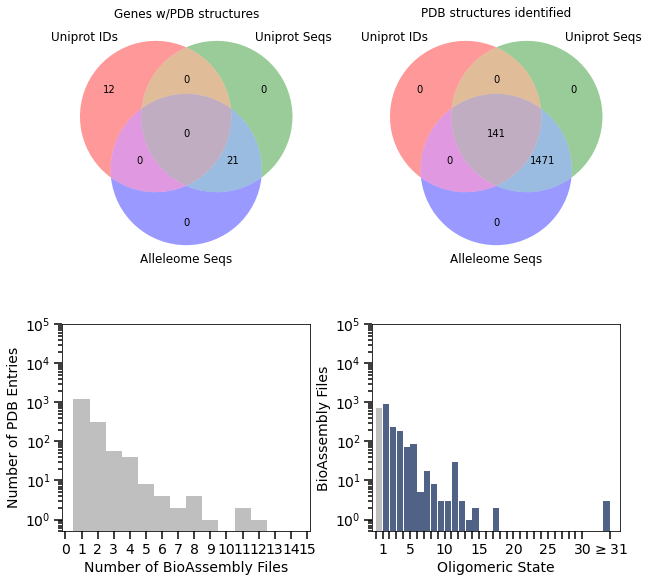

In [33]:
fig,ax =plt.subplots()
fig.set_figheight(10) 
fig.set_figwidth(10)
gs1 = gridspec.GridSpec(2,2 ,height_ratios= [1.5,1], width_ratios=[1,1])
gs1.update( wspace=0.25, hspace = 0.1)
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[0,1])
ax3 = plt.subplot(gs1[1,0])
ax4 = plt.subplot(gs1[1,1])

data = [textService_UniToPDB, textService_PDBinfo, sequenceService_UniProt, sequenceService_Alleleome]
figuresModule.figS6_AB(data, query ='genes',fig = fig , ax = ax1,save = False)
figuresModule.figS6_AB(data, query ='structures',fig = fig, ax = ax2,save = False)
figuresModule.figS6_C(dfbioassembly,fig = fig, ax = ax3,save = False)
figuresModule.figS6_D(dfbioassembly,fig = fig, ax = ax4,save = False)
plt.show()

##### 002C - Map the PDB-API data back to the bioassembly structures

In [34]:
########### 
infile = op.join(qspace.DataOutput_dir, '002A-ALL_mapped_PDBS.csv')
allMappedPDBs_PDBinfo = pd.read_csv(infile,index_col=0)  
########### 
infile = op.join(qspace.DataOutput_dir,'002A-uniprot_to_pdb.csv') 
textService_UniToPDB = pd.read_csv(infile)
########### 
infile = op.join(qspace.DataOutput_dir,'002A-uniprot_to_pdb_full_info.csv') 
textService_PDBinfo = pd.read_csv(infile)
########### 
query_type = "UniProt"
json_file = op.join(qspace.DataOutput_dir,'002A-BLAST_PDB_{}Seq.json'.format(query_type)) 
if op.exists(json_file):
    with open(json_file, 'rb') as f:
        sequenceService_UniProt = json.load(f)
    sequenceService_UniProt = ast.literal_eval(sequenceService_UniProt)
########### 
query_type = "Alleleome"
json_file = op.join(qspace.DataOutput_dir,'002A-BLAST_PDB_{}Seq.json'.format(query_type)) 
if op.exists(json_file):
    with open(json_file, 'rb') as f:
        sequenceService_Alleleome = json.load(f)
    sequenceService_Alleleome = ast.literal_eval(sequenceService_Alleleome)

########### df bioassembly
infile = op.join(qspace.DataOutput_dir,'002B-ALL_mapped_BIOASSEMBLY.csv') 
dfbioassembly = pd.read_csv(infile)


<i>Map the PDB sequence service scores back to bioassembly files. This information is mapped to each bioassembly chain for each oligomeric state present.</i>

In [35]:
time_block_start = time.time()
pdbMaps,bioMaps= pdbModule.run_002C_mapAPI_DataToBioassemblies(sequenceService_api_result= sequenceService_UniProt,
                                                                dfpdb_mapped = allMappedPDBs_PDBinfo,
                                                                dfbioassembly = dfbioassembly,
                                                                query_type = 'Uniprot',
                                                                chain_source = 'auth_asym_ids')
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '002C', time_start=time_block_start)
comp_time_data.update({'2C' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Getting PDB-chain-gene mapping quality...
---------------------------


A Jupyter Widget


INFO:_pdbModule._002C_geneChainQuality_for_PDB_and_Bioassembly:Saving PDB-chain-gene mapping...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/002C-Uniprot-PDB_quality.json
Transfering PDB-chain-gene mapping quality to PDB bioassembly files...
---------------------------


A Jupyter Widget


INFO:_pdbModule._002C_geneChainQuality_for_PDB_and_Bioassembly:Saving PDB Bioassembly-chain-gene mapping...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/002C-Uniprot-BIO_quality.json

Computation Time
--------------------------
002C :  0.0m  4.0s


##### 002D - Find PSEUDO-STRUCURES for each PDB/bioassembly structure

In [36]:
with open(op.join(qspace.DataOutput_dir, "000A-uniprot_blattner_mapping.json"), 'rb') as f:
    blattnerUniprotMapping = json.load(f)
dfseq = op.join(qspace.DataOutput_dir, '001D-dfrepseq.csv')
dfseq = pd.read_csv(dfseq, index_col=0)


########### 
json_file = op.join(qspace.DataOutput_dir,'002C-Uniprot-PDB_quality.json') 
if op.exists(json_file):
    with open(json_file, 'rb') as f:
        pdbMaps = json.load(f)
#     sequenceService_UniProt = ast.literal_eval(sequenceService_UniProt)
########### 
json_file = op.join(qspace.DataOutput_dir,'002C-Uniprot-BIO_quality.json') 
if op.exists(json_file):
    with open(json_file, 'rb') as f:
        bioMaps = json.load(f)
#     sequenceService_UniProt = ast.literal_eval(sequenceService_UniProt)


infile = op.join(qspace.DataOutput_dir, '002A-PDBstructureInfo.csv')
dfpdb_structure_info = pd.read_csv(infile,index_col=0)  
dfpdb_structure_info.head()

,pdb_id,release_date,resolution,structure_type
0,3B5Y,2007-12-04T00:00:00Z,4.5,experimental
1,4ZMS,2016-04-27T00:00:00Z,1.9,experimental
2,4YMV,2015-04-22T00:00:00Z,3.003,experimental
3,3DFG,2008-11-04T00:00:00Z,1.5,experimental
4,1WP1,2004-11-02T00:00:00Z,2.56,experimental


<i>Find best pseudo-structures for PDB bioassembly files.</i>
1) Determine all unique gene stoichiometries that can recreate the structure-chain stoichiometry based on the sequence service API hits that were mapped to the PBDs and to the Bioassembly files.

2) Then rank each pseudo-structure for each unique gene-stoichiometry

3) Select the best pseudo-structure for each unique gene-stoichiometry

4) Download the PDB/CIF files (if not so already)

5) Determine all chain-seqs in the downloaded PDB files

6) Run needle alignment between the chain-seqs and the Uniprot gene-seqs to find the true quality of the pseudo-structure (The PDB API quality metric is relative)

In [37]:
time_block_start = time.time()
dfpseudo_pdb, dfpseudo_pdb_best = pdbModule.run_002D_pseudo_structures(bioMaps=bioMaps,
                                                                       dfrepseq = dfseq,
                                                                       query_type = 'PDB',
                                                                       dfpdb_structure_info = dfpdb_structure_info)
pdb_download_errors = pdbModule.run_002D_downloadPDBfiles(dfpseudo_pdb_best,
                                                          pdb_folder = qspace.pdbStructuresDir,
                                                          force_rerun = force_rerun_global,
                                                          download_errors = []
                                                         )
dfStructureSeqs = pdbModule.run_002D_getAASeqInPDBFile(dfpseudo_pdb_best,                               
                                                       force_rerun = force_rerun_global)

dfpseudo_pdb_best_needle = pdbModule.run_002D_needle_alignment_quality(dfbest=dfpseudo_pdb_best,
                                                           dfStructureSeqs_all=dfStructureSeqs,
                                                           dfrepseq = dfseq,
                                                           needle_dir = qspace.SequenceAlignmentDir,
                                                           checked = [],
                                                           force_rerun =  force_rerun_global
                                                          )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '002D', time_start=time_block_start)
comp_time_data.update({'2D' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Finding Pseudo-Structures for PDB structures...
----------------------------


A Jupyter Widget

A Jupyter Widget


Getting gene-chain quality for Pseudo-Structures...
----------------------------


A Jupyter Widget


Making Dataframe...........
-------------------


A Jupyter Widget


Checking Dataframe...........
-------------------


A Jupyter Widget


Finding Unique Gene Stoich...........
-------------------


A Jupyter Widget


Assigning Unique Gene Stoich as String...........
-------------------


A Jupyter Widget


Assigning Identical Structures & AA Enzyme Length...........
-------------------


A Jupyter Widget

A Jupyter Widget


Getting total structure quality for Pseudo-Structures...
----------------------------
Finding Total Match Quality...........
-------------------


A Jupyter Widget


Ranking Pseudo-Structures by total quality...
----------------------------
Ranking Matches...........
-------------------


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Determining best quality Pseudo-Structures...
----------------------------
Finding Best Matches...........
-------------------
79 Unique gene stoichiometries from 1507 PDB structures...


A Jupyter Widget


INFO:_pdbModule._002D_PDBbioassemblyPseudoStructures:Saving ALL PDB pseudo-structures ...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/002D-all_structures_PDB.csv
INFO:_pdbModule._002D_PDBbioassemblyPseudoStructures:Saving BEST PDB pseudo-structures ...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/002D-best_structures_PDB.csv
----------------------------


A Jupyter Widget


Getting AA sequences in each chain of 63 .pdb structure files......
------------------


A Jupyter Widget



There were errors using the .pdb files for 0 structures......
-----------------------
Getting AA sequences in each chain of 0 .cif structure files......
-----------------------


A Jupyter Widget


INFO:_pdbModule._002D_PDBbioassemblyPseudoStructures:Saving Dataframe of all AA seqs for all chains in PDB/CIF files...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/002D-chain_seqs_from_PDBs.csv
Using needle alignment to get sequence identify of all chains in 79 structure files.....
---------------------------------


A Jupyter Widget


Finding Total Match Quality...........
-------------------


A Jupyter Widget


Ranking Matches...........
-------------------


A Jupyter Widget

A Jupyter Widget


INFO:_pdbModule._002D_PDBbioassemblyPseudoStructures:Saving BEST PDB pseudo-structures w/needle alignment quality...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/002D-best_structures_PDB.csv

Computation Time
--------------------------
002D :  0.0m  1.4s


##### Fig. S7

In [38]:
dfpseudo_swiss        = pd.read_csv(op.join(qspace.DataOutput_dir,'001F-all_structures_SWISS.csv'), index_col=0)
dfpseudo_swiss_best   = pd.read_csv(op.join(qspace.DataOutput_dir,'001F-best_structures_SWISS.csv'), index_col=0)
dfpseudo_itasser      = pd.read_csv(op.join(qspace.DataOutput_dir,'001F-all_structures_ITASSER.csv'), index_col=0)
dfpseudo_itasser_best = pd.read_csv(op.join(qspace.DataOutput_dir,'001F-best_structures_ITASSER.csv'), index_col=0)
dfpseudo_alphafold    = pd.read_csv(op.join(qspace.DataOutput_dir,'001F-all_structures_ALPHAFOLD.csv'), index_col=0)

dfpseudo_pdb                = pd.read_csv(op.join(qspace.DataOutput_dir,'002D-all_structures_PDB.csv'), index_col=0)
dfpseudo_pdb_best_needle    = pd.read_csv(op.join(qspace.DataOutput_dir,'002D-best_structures_PDB.csv'), index_col=0)

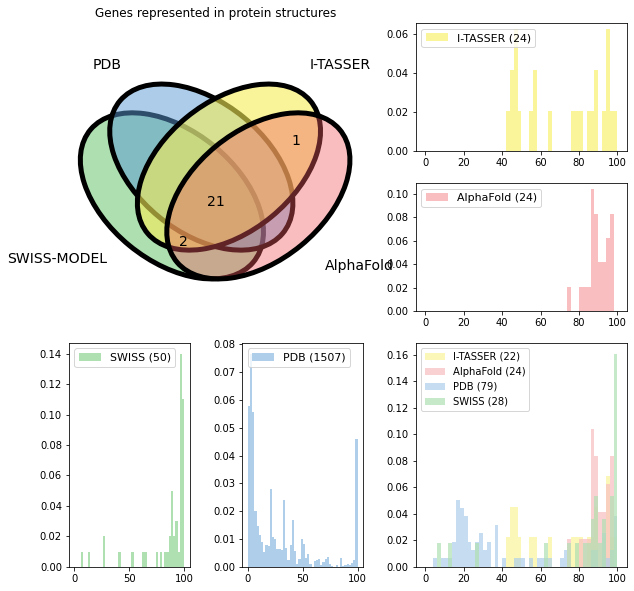

In [39]:
def get_genes_from_dfpseudo(dfpseudo):
    genes_covered = []
    for gs in dfpseudo.gene_stoichiometry.values:
        if type(gs) == str:
            gs = ast.literal_eval(gs)
        genes_covered += gs.keys()
    return set(genes_covered)

fig,ax =plt.subplots()
fig.set_figheight(10) 
fig.set_figwidth(10)
gs1 = gridspec.GridSpec(3,3 ,height_ratios= [1,1,1.75], width_ratios=[1,1,1.75])
gs1.update( wspace=0.35, hspace = 0.2)
ax1 = plt.subplot(gs1[0:2,0:2])
ax2 = plt.subplot(gs1[0,2])
ax3 = plt.subplot(gs1[1,2])
ax4 = plt.subplot(gs1[2,0])
ax5 = plt.subplot(gs1[2,1])
ax6 = plt.subplot(gs1[2,2])


genes_swiss = get_genes_from_dfpseudo(dfpseudo_swiss)
genes_pdb = get_genes_from_dfpseudo(dfpseudo_pdb)
genes_itasser = get_genes_from_dfpseudo(dfpseudo_itasser)
genes_alphafold = get_genes_from_dfpseudo(dfpseudo_alphafold)
data = [genes_swiss,genes_pdb,genes_itasser,genes_alphafold]
figuresModule.figS7_A(data,fig = fig, ax = ax1, save = False)

figuresModule.figS7_BCDE(dfpseudo= dfpseudo_itasser,fig = fig, ax = ax2,save = False, legend = True, query = 'ITASSER')
figuresModule.figS7_BCDE(dfpseudo= dfpseudo_swiss,fig = fig, ax = ax4,save = False, legend = True, query = 'SWISS')
figuresModule.figS7_BCDE(dfpseudo= dfpseudo_pdb,fig = fig, ax = ax5,save = False, legend = True, query = 'PDB')
figuresModule.figS7_BCDE(dfpseudo= dfpseudo_alphafold,fig = fig, ax = ax3,save = False, legend = True, query = 'ALPHAFOLD')

data = {"ITASSER" : dfpseudo_itasser_best,
        "SWISS" : dfpseudo_swiss_best,
        "PDB" : dfpseudo_pdb_best_needle,
        "ALPHAFOLD" : dfpseudo_alphafold,}

figuresModule.figS7_F(data,fig = fig, ax = ax6, save = False, legend = True, )
plt.show()

In [40]:
print( '\nComputation Time\n--------------------------')
get_computation_time(label = 'PDB Module', time_start=time_module_start)



Computation Time
--------------------------
PDB Module :  0.0m  10.0s


10.031179904937744

# Protein-Target-Annotation Module (#003A-D)
- <b>#003A</b> --  Find annotated proteins and oligomerization states
- <b>#003B</b> --  Structure-guided re-annotation of monomers w/structural evidence of oligomerization
- <b>#003C</b> --  Prep large oligomers for de novo structure generation with Alphafold Multimer
- <b>#003D</b> --  QCQA Alphafold Multimer models 

In [41]:
#computation time
time_module_start = time.time()

In [42]:
#### Inputs needed to run 003A-D ####

infile = op.join(qspace.Input_dir, '003A-enzyme_targets_ecocyc.csv')
proteinAnnot_ecocyc_input = pd.read_csv(infile, index_col=0,engine='python')

infile = op.join(qspace.Input_dir, '003A-enzyme_targets_cobraME.json')
with open(infile ,'r') as f:
    proteinAnnot_cobraME_input = json.load(f)
    
#### Inputs needed to run 003A-D ####
dfseq = op.join(qspace.DataOutput_dir, '001D-dfrepseq.csv')
dfseq = pd.read_csv(dfseq, index_col=0)

##### 003A - Determine protein complexes and their gene-stochiometry

<i>We obtain this information for E.coli from genome-scale model iJL1678b-ME and from EcoCyc. By default, QSPACE adds genes that are in our gene-list query but not in one of these two sources of protein complexes as "Unmodelled_monomer_{geneid}". </i>

iJL1678b : https://github.com/SBRG/ecolime/blob/master/ecolime/building_data/protein_complexes.txt

Ecocyc : https://biocyc.org/group?id=biocyc14-463-3819036113


In [43]:
time_block_start = time.time()
proteinAnnot_ecocyc,genes_ecocyc= pTAM.run_003A_get_protein_annotations_ecocyc(proteinAnnot_ecocyc_input, queryGeneList=qspacegeneList)
# proteinAnnot_ecocyc,genes_ecocyc =filter_cplx_for_genes_not_in_query(proteinAnnotation=proteinAnnot_ecocyc,)

proteinAnnot_cobrame,genes_cobrame= pTAM.run_003A_get_protein_annotations_cobrame(proteinAnnot_cobraME_input,queryGeneList=qspacegeneList)
# proteinAnnot_cobrame,genes_cobrame =filter_cplx_for_genes_not_in_query(proteinAnnotation=proteinAnnot_cobrame, queryGeneList=qspacegeneList)

genes_found = genes_ecocyc.union(genes_cobrame)
proteinAnnot_unmodeled,genes_unmodeled= pTAM.run_003A_get_protein_annotations_unmodeled(dfrepseq = dfseq, 
                                                                                        genes_covered=genes_found)

proteinTargets, proteinTargetsMissing, genesMissing = pTAM.run_003A_get_protein_annotations_final(proteinAnnotations_ecocyc=proteinAnnot_ecocyc,
                                                                                                  proteinAnnotations_cobrame=proteinAnnot_cobrame,
                                                                                                  proteinAnnotations_unmodeled=proteinAnnot_unmodeled,
                                                                                                  dfrepseq=dfseq
                                                                                                 )
print( '\nComputation Time\n--------------------------')
time_point =get_computation_time(label = '003A', time_start=time_block_start)
comp_time_data.update({'3A' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)
proteinTargets


EcoCyc annotations
-------------------------------
-----------------------------
Removed 461 Protein complexes due insufficient query genes
-----------------------------
Found   9 Genes

CobraME iJL1678b-ME  annotations
-------------------------------
-----------------------------
Removed 1305 Protein complexes due insufficient query genes
-----------------------------
Found   12 Genes

Unmodelled gene annotations
-------------------------------
Compiling Ecocyc Protein Complex Annotations
------------------------------


A Jupyter Widget


Compiling Unmodelled Protein Monomer Annotations
------------------------------


A Jupyter Widget


Compiling CobraME-iJL1678b Protein Complex Annotations
------------------------------


A Jupyter Widget


Determining source of protein complex annotations
------------------------------


A Jupyter Widget


Determining protein complex amino acid sequence
------------------------------


A Jupyter Widget


INFO:_proteinTargetAnnotationModule._003A_getProteinTargetAnnotations:Saving Protein Target Annotations (prior to structure-guided re-annotation...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/003A-enzyme_targets_prior_to_BFS.csv

Computation Time
--------------------------
003A :  0.0m  1.0s


,gene_stoich,cobraME-enzyme,description,cobrame,unmodelled,ecocyc,monomer_type,k_mer,gene_string,len_gene_string
CPLX0-3301,{'b0880': 2},NaN,DNA replication inhibitor CspD,NaN,NaN,True,mono,2,MEKGTVKWFNNAKGFGFICPEGGGEDIFAHYSTIQMDGYRTLKAGQ...,149
CPLX0-4,"{'b3240': 3, 'b3241': 6}",NaN,aromatic carboxylic acid efflux pump = [AaeA][...,NaN,NaN,True,hetero,9,MGIFSIANQHIRFAVKLATAIVLALFVGFHFQLETPRWAVLTAAIV...,3833
CPLX0-7666,{'b0034': 2},NaN,DNA-binding transcriptional activator CaiF,NaN,NaN,True,mono,2,MCEGYVEKPLYLLIAEWMMAENRWVIAREISIHFDIEHSKAVNTLT...,263
CPLX0-7964,{'b3035': 3},EG11009-MONOMER,outer membrane channel TolC,True,NaN,True,mono,3,MKKLLPILIGLSLSGFSSLSQAENLMQVYQQARLSNPELRKSAADR...,1481
CPLX0-7983,{'b0808': 7},NaN,moderate conductance mechanosensitive channel ...,NaN,NaN,True,mono,7,MRWILFILFCLLGAPAHAVSIPGVTTTTTTDSTTEPAPEPDIEQKK...,5193
CPLX0-8016,{'b0179': 3},UDPHYDROXYMYRGLUCOSAMNACETYLTRANS-MONO,UDP-3-O-(3-hydroxymyristoyl)glucosamine�N-acyl...,True,NaN,True,mono,3,MPSIRLADLAQQLDAELHGDGDIVITGVASMQSAQTGHITFMVNPK...,1025
TRANS-200-CPLX,"{'b3035': 3, 'b0878': 6, 'b0879': 2}",NaN,ABC-type tripartite efflux pump = [(TolC)3][Ma...,NaN,NaN,True,hetero,11,MKKLLPILIGLSLSGFSSLSQAENLMQVYQQARLSNPELRKSAADR...,5011
Unmodelled_MONOMER_b2336,{'b2336': 1},NaN,NaN,NaN,True,NaN,mono,1,MSDLLCSAKLGAMTLALLLSATSLSALASVTPDRTRLIFNESDKSI...,250
Unmodelled_MONOMER_b1221,{'b1221': 1},NaN,NaN,NaN,True,NaN,mono,1,MSNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIE...,216
Unmodelled_MONOMER_b0107,{'b0107': 1},NaN,NaN,NaN,True,NaN,mono,1,MNIPQLTALCLRYHGVLLDASEEVVHVAVVDAPSHELLDALHFATT...,461


###### 003B - QCQA structural evidence of oligomerization in annotated monomers

<i>QSPACE determines which annotated monomers can be mapped to oligomeric structures. There is a semi-automatic pipeline that determines the oligomerization state. For each step, QSPACE will save a .csv file (filename starts with "003B") with the oligomeric structures that are mapped to each annotated monomer (qspace.DataOutput_dir). The user will have to manually curate these files and save them in the qspace.Input_dir. We have done this for E.coli and saved the files in Manuscript/Inputs/.</i>

In [44]:
time_block_start = time.time()
#import the best pseudo structures
#PDB
dfpdb_structures = pd.read_csv(op.join(qspace.DataOutput_dir,'002D-best_structures_PDB.csv'),index_col=0)
#SWISS
dfswiss_structures = pd.read_csv(op.join(qspace.DataOutput_dir,'001F-best_structures_SWISS.csv'),index_col=0)

def ensure_ast(df, column_list):
    for col in column_list:
        changeDict = df.get(col).to_dict()
        for k, v in changeDict.items():
            if type(v) == str:
                v = ast.literal_eval(v)
            changeDict.update({k : v})
        df[col] = pd.Series(changeDict) 
    return df

dfpdb_structures = ensure_ast(dfpdb_structures, column_list= ['gene_stoichiometry','pdb_quality_needle','identical_structures'])
dfpdb_structures['pdb_quality'] = dfpdb_structures['pdb_quality_needle'] 
dfswiss_structures = ensure_ast(dfswiss_structures, column_list= ['gene_stoichiometry','pdb_quality','identical_structures'])

##### get combinind PDB/SWISS STRUCTURES
appender_index = []
appender = list(dfpdb_structures.drop(['pdb_quality_needle','pdb_entry'], axis = 1).to_records(index=False))
appender_index += dfpdb_structures.index.tolist()

appender2 = list(dfswiss_structures.to_records(index=False))
appender_index += dfswiss_structures.index.tolist()
print (len(appender), len(appender2))

appender += appender2
print (len(appender))
dfpdb_and_swiss_structures = pd.DataFrame.from_records(appender, index = appender_index, columns=dfpdb_structures.drop(['pdb_quality_needle','pdb_entry'], axis = 1).columns)



79 28
107


In [45]:
#### Structural Evidence used to re-annotate protein complexes
new_recipes = {}
df_recipes_changed = pd.DataFrame(columns= ['finalGeneStoich', 'stoichChanged',
                                            'method', 'caseNum', 'evidenceSupported',
                                            'evidenceIgnored'])


results_pdb= pTAM.run_003B_monomers(proteinTargets,
                                    df_structures=dfpdb_structures,
                                    query = 'PDB'
                                   )
[df_pdb, stoich_pdb, quality_pdb, output_pdb, to_bfs_pdb, full_pdb, homo_oligo_pdb, hetero_oligo_pdb,monomerAnnot ] = results_pdb
results_swiss= pTAM.run_003B_monomers(proteinTargets,
                                    df_structures=dfswiss_structures,
                                    query = 'SWISS'
                                   )
[df_swiss, stoich_swiss, quality_swiss, output_swiss, to_bfs_swiss, full_swiss, homo_oligo_swiss, hetero_oligo_swiss,monomerAnnot ] = results_swiss

structuralEvidence = {"hetero_pdb":hetero_oligo_pdb,
                      "homo_pdb":homo_oligo_pdb,
                      "homo_swiss":homo_oligo_swiss,
                      'full_pdb':full_pdb,
                     'full_swiss':full_swiss}

df_hetero_oligo = pTAM.run_003B_HeteroOligos(structuralEvidence= structuralEvidence,
                                             monomer_parent=monomerAnnot,
                                             quality_pdb=quality_pdb,
                                             blast_cutoff = 80)



new_recipes, df_recipes_changed = pTAM.run_003B_caseV_HeteroOligos(dfpdb_and_swiss_structures,
                                                                    curation_confirmed = True,
                                                                    monomer_parent = monomerAnnot,
                                                                   new_recipes=new_recipes,
                                                                   df_recipes_changed=df_recipes_changed,
                                                                   
                                                              )
new_recipes, df_recipes_changed = pTAM.run_003B_caseII_autoQCQA_SwissHomoOligos(structuralEvidence=structuralEvidence,
                                                                         df_swiss = df_swiss,
                                                                         real_structure_stoich_swiss = stoich_swiss,
                                                                         dfpdb_and_swiss_structures=dfpdb_and_swiss_structures,
                                                                         new_recipes = new_recipes,    
                                                                         df_recipes_changed = df_recipes_changed,
                                                                         monomer_parent = monomerAnnot,
                                                                                proteinAnnotation= proteinTargets,
                                                                        )
df_homo_pdb = pTAM.run_003B_caseIV_run_HomoOligos(structuralEvidence,
                                           monomer_parent = monomerAnnot,
                                           dfpdb_structures=df_pdb,
                              )
new_recipes,df_recipes_changed = pTAM.run_003B_caseIV_handle_HomoOligos(dfpdb_and_swiss_structures = dfpdb_and_swiss_structures,
                                 new_recipes = new_recipes,    
                                 df_recipes_changed = df_recipes_changed,
                                 curation_confirmed = True,
                                 monomer_parent = monomerAnnot,
                                )
new_recipes,df_recipes_changed = pTAM.run_003B_caseI_homoOligos_PDB_and_SWISS(structuralEvidence=structuralEvidence,
                                                                        df_swiss = df_swiss,
                                                                        df_pdb= df_pdb,
                                                                        dfpdb_and_swiss_structures=dfpdb_and_swiss_structures,
                                                                        real_structure_stoich_swiss = stoich_swiss ,
                                                                        oldProteinAnnotation = proteinTargets ,
                                                                        monomer_parent= monomerAnnot,
                                                                        new_recipes = new_recipes,
                                                                        df_recipes_changed =df_recipes_changed
                                                                       )
new_recipes,df_recipes_changed = pTAM.run_003B_caseIII_handle_HomoOligos_PDB_and_SWISS(new_recipes = new_recipes,
                                                                               df_recipes_changed = df_recipes_changed,
                                                                               curation_confirmed = True,
                                                                               monomer_parent = monomerAnnot,
                                                                               
                                                                              )
df_recipes_changed['evidenceSupported'] =df_recipes_changed['evidenceQuality']
df_recipes_changed = df_recipes_changed.drop('evidenceQuality', axis = 1)
outfile = op.join(qspace.DataOutput_dir, '003B-supplement-enzyme_stoichs_changed.csv')
df_recipes_changed.to_csv(outfile)
# print "Saving....\n\t> {}".format(outfile)

new_data,translation,proteinTargetsNew = pTAM.run_003B_rename_enzymes(new_recipes,
                                                                      dfparent= proteinTargets,
                                                                      dfrepseq = dfseq)

oligomer_parent= proteinTargetsNew[proteinTargetsNew.k_mer.isin([1,'1']) == False]

print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '003B', time_start=time_block_start)
comp_time_data.update({'3B' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Found 10 annotated or unmodelled monomers...


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Found 10 annotated or unmodelled monomers...


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

/usr/local/lib/python3.7/dist-packages/pandas/compat/_optional.py:124: UserWarning: Pandas requires version '0.9.8' or newer of 'xlsxwriter' (version '0.7.3' currently installed).
  warnings.warn(msg, UserWarning)


INFO:_proteinTargetAnnotationModule._003B_structureGuidedReannotation:Saving Hetero-oligomer evidence from PDB only for manual curation...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/003B-hetero_oligo_evidence_needs_curation.xlsx
CASE V (passed)
------------------------------------------
Importing Manual Curation...
CASE II (all)
------------------------------------------
Auto QCQA for SWISS homo-oligomers...
Confirmed 1 of 1 Genes as Homo-Oligomers
INFO:_proteinTargetAnnotationModule._003B_structureGuidedReannotation:Auto SWISS Curation : added new recipe for 1 enzymes using only SWISS data
CASE IV (all)
------------------------------------------
Analyzing 1 Structures with ONLY PDB Homo-k-mer Structures...
INFO:_proteinTargetAnnotationModule._003B_structureGuidedReannotation:Saving Homo-oligomer evidence from PDB only for manual curation...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/003B-df_homo_pdb_only_needs_curation.xl

A Jupyter Widget


SWISS homo-k-mer results


A Jupyter Widget


Found SWISS & PDBD Homo-Oligomerization evidence for 6 Genes
	4 of 6 Oligomers need Manual Curation
	2 of 6 Oligomers AUTO Confirmed
INFO:_proteinTargetAnnotationModule._003B_structureGuidedReannotation:AUTO Curation added new recipe for 2 enzymes using PDB & SWISS data
INFO:_proteinTargetAnnotationModule._003B_structureGuidedReannotation:Saving Homo-oligomer evidence from PDB and SWISS for manual curation...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/003B-df_homo_pdb_and_swiss_needs_curation.csv
Case III (passed)
-----------------------------------
Original Enzymes :  20
Incorrect Monomers :  6
Identified New Oligomers :  6


A Jupyter Widget


INFO:_proteinTargetAnnotationModule._003B_structureGuidedReannotation:Saving NEW protein (target) complex annotations...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/003B-enzyme_targets_with_new_oligomers.csv

Computation Time
--------------------------
003B :  0.0m  0.7s


###### Fig S8

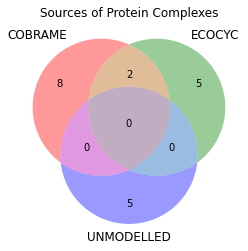

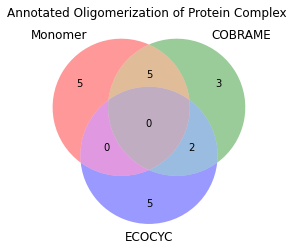

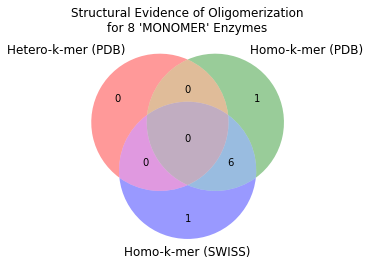

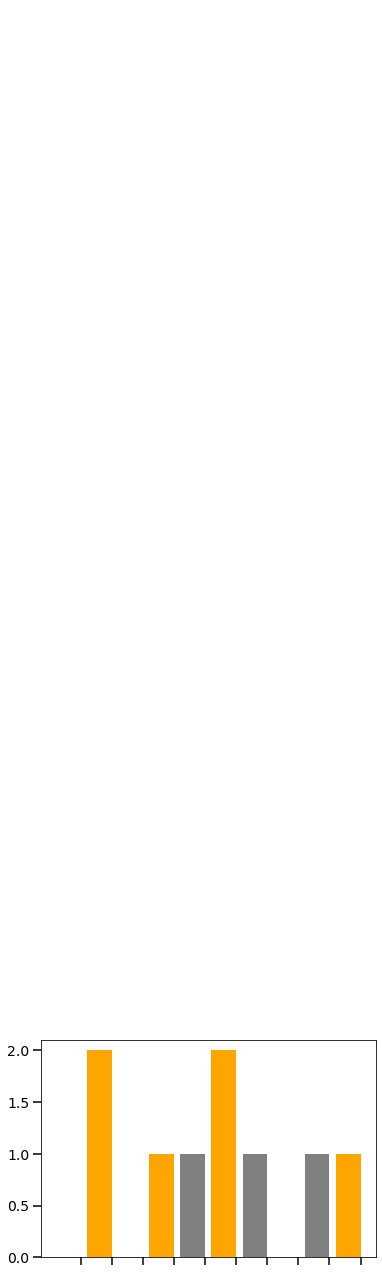

In [46]:
figuresModule.figS8_A(proteinTargets,fig = False, ax = False, save = False)
figuresModule.figS8_B(proteinTargets,fig = False, ax = False, save = False)
figuresModule.figS8_C(hetero_oligo_pdb, homo_oligo_pdb,homo_oligo_swiss,fig = False, ax = False, save = False)
figuresModule.figS8_D(df_recipes_changed,fig = False, ax = False, save = False)


##### 003C - Prepare oligomeric proteins for Alphafold Multimer)

<i>QSPACE determines which annotated oligomers lack structural data and need to be sent of AF-Mulitmer/ColabFold. It saves complex-level amino acid sequences in qspace.AlphaMultiSeqDir. These sequences should be uploaded to ColabFold and the AF-Multimer result folders should be downloaded in qspace.alphafoldMultimerDir.  </i>

ColabFold : https://github.com/sokrypton/ColabFold

We used the AlphaFold2_batch and ran AlphaFold Multimer v2 for the manuscript. 

In [47]:
infile = op.join(qspace.DataOutput_dir,'003A-enzyme_targets_prior_to_BFS.csv')
proteinTargetsOld = pd.read_csv(infile,index_col=0)

infile = op.join(qspace.DataOutput_dir,'003B-enzyme_targets_with_new_oligomers.csv')
proteinTargetsNew = pd.read_csv(infile,index_col=0)

enzymes = proteinTargetsOld[proteinTargetsOld.k_mer > 1]
print ("OLD Number of Multimeric Enzymes : ", len(enzymes))

enzymes = proteinTargetsNew[proteinTargetsNew.k_mer > 1]
print ("NEW Number of Multimeric Enzymes : ", len(enzymes))


OLD Number of Multimeric Enzymes :  10
NEW Number of Multimeric Enzymes :  16


In [48]:
oligomer_parent= proteinTargetsNew[proteinTargetsNew.k_mer.isin([1,'1']) == False]


In [49]:
time_block_start = time.time()
results_pdb= pTAM.run_003C_oliogmers(oligomer_parent,
                                    df_structures=dfpdb_structures,
                                    query = 'PDB'
                                   )
[df_pdb, stoich_pdb, quality_pdb, output_pdb, to_bfs_pdb, full_pdb, homo_oligo_pdb, hetero_oligo_pdb,oligomerAnnot ] = results_pdb
results_swiss= pTAM.run_003C_oliogmers(oligomer_parent,
                                    df_structures=dfswiss_structures,
                                    query = 'SWISS'
                                   )
[df_swiss, stoich_swiss, quality_swiss, output_swiss, to_bfs_swiss, full_swiss, homo_oligo_swiss, hetero_oligo_swiss,oligomerAnnot] = results_swiss

structuralEvidence = {"hetero_pdb":hetero_oligo_pdb,
                      "homo_pdb":homo_oligo_pdb,
                      "homo_swiss":homo_oligo_swiss,
                      'full_pdb':full_pdb,
                     'full_swiss':full_swiss}

dfOligomerMissing = pTAM.run_003C_find_missing_oligos(structuralEvidence =structuralEvidence ,
                                                      oligomer_parent=oligomer_parent,
                                                      dfpdb_and_swiss_structures=dfpdb_and_swiss_structures,
                                                      df_swiss=df_swiss
                                                     )
sent_to_AFmultimer = pTAM.run_003C_sendCplxSeqs_to_AFMultiFolder(df_oligo_missing=dfOligomerMissing, 
                                                                 outdir = qspace.AlphaMultiSeqDir,
                                                                 alphafold_seq_len_cutoff = 2000,
                                                                 remove_old_seqs= True,
                                                                )

sent_to_AFmultimer_byParts = pTAM.run_003C_sendByPartsSeqs_to_AFMultiFolder(df_oligo_missing=dfOligomerMissing, 
                                                                    dfrepseq=dfseq,
                                                                    outdir = qspace.AlphaMultiSeqDir,
                                                                    alphafold_seq_len_cutoff = 2000,
                                                                    remove_old_seqs= False,
                                                                   )
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '003C', time_start=time_block_start)
comp_time_data.update({'3C' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Sending 2 of 5 Protein complexes to Alphafold Multimer .....
-----------------------------------------
3 Protein complexes are large than the 2000 AA sequence cutoff
INFO:_proteinTargetAnnotationModule._003C_prepAF_Multimer:Saving protein oligomers > 2000 AAs for manual curation and send to alphafold multimer...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/003C-too_long_for_alphafold.csv
INFO:_proteinTargetAnnotationModule._003C_prepAF_Multimer:Importing protein oligomers > 2000 AAs after manual curation ...
	/home/ecatoiu/Projects/QSPACE_install/QSPACE/Manuscript/Inputs/003C-alphafoldMultimerByParts.csv

Computation Time
--------------------------
003C :  0.0m  0.2s


##### 003D - QCQA AF-Multimer results

<i>QSPACE will QCQA alphafold multimer results downloaded to qspace.alphafoldMultimerDir. For models that do not pass our automatic QCQA (Multimer Score $<$ 0.8), we manually inspect the models using NGLview and make a determination if the model is passable. For E.coli, the manual curation is found in Manuscript/Inputs/003D-alphafoldMultimer_Results_after_manual_curation.csv  </i>


In [50]:
time_block_start = time.time()
queryAF = sent_to_AFmultimer.index.tolist() + sent_to_AFmultimer_byParts.index.tolist()

dfalphamulti, AFchain_quality_dict,AFchain_geneStoich_dict = pTAM.run_003D_autoQCQA_AFMultimerModels(queryAF=queryAF,
                                                                             dfseq = dfseq,
                                                                             alphaFoldMultimer_dir = qspace.alphafoldMultimerDir,
                                                                            )

dfalphamulti_curated = pTAM.run_003D_loadManualQCQA_AFMultimerModels(queryAF)

dfpseudo_alphaMulti_best = pTAM.run_003D_pseudoStructures_AF_best(dfalpha=dfalphamulti_curated,
                                                     geneStoich_dict= AFchain_geneStoich_dict,
                                                     quality_dict  = AFchain_quality_dict
                                                    )   
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '003D', time_start=time_block_start)
comp_time_data.update({'3D' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Running QCQA on Alphafold Multimers...
---------------------------------


A Jupyter Widget


Confirming gene-chain seq quality for 4 AF multimer .pdb files
---------------------------------


A Jupyter Widget

A Jupyter Widget


INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Saving AF multimer dataframe that needs manual curation of model w/scores <0.80 ....
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/003D-alphafold_Multimer_Results_needs_manual_curation.csv
INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Using manual curation QCQA dataframe for AF multimers
	/home/ecatoiu/Projects/QSPACE_install/QSPACE/Manuscript/Inputs/003D-alphafold_Multimer_Results_after_manual_curation.csv
INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Saving AF multimer pseudo-structure information dataframe for 3 models passing QCQA ....
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/003D-best_structures_AlphafoldMultimer.csv

Computation Time
--------------------------
003D :  0.0m  2.2s


In [51]:
#sequence alignment for AF-Multimer structures
pTAM.run_003D_needle_alignment_AFMulti(AFchain_quality_dict=AFchain_quality_dict,
                                  dfalphamulti=dfalphamulti,
                                  dfrepseq = dfseq,
                                  force_rerun = True)

INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Aligning...	b3240_3__AlphaMulti_b3240_P46481-A.needle
INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Aligning...	b3240_3__AlphaMulti_b3240_P46481-B.needle
INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Aligning...	b3240_3__AlphaMulti_b3240_P46481-C.needle
INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Aligning...	CPLX0-7666_AlphaMulti_b0034_P0AE58-B.needle
INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Aligning...	CPLX0-7666_AlphaMulti_b0034_P0AE58-C.needle
INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Aligning...	ABC-26-CPLX_AlphaMulti_b2677_P14175-A.needle
INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Aligning...	ABC-26-CPLX_AlphaMulti_b2677_P14175-B.needle
INFO:_proteinTargetAnnotationModule._003D_qcqaAlphafoldMultimerModels:Aligning...	ABC-26-CPLX_AlphaMulti_b2678_P14176-C.ne

([], [])

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Alphafold Multimer Score'>)

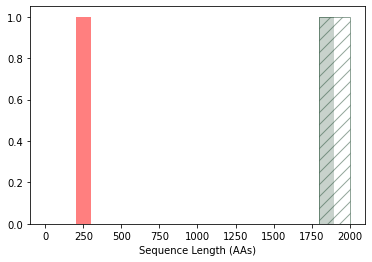

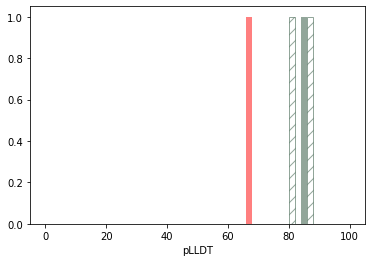

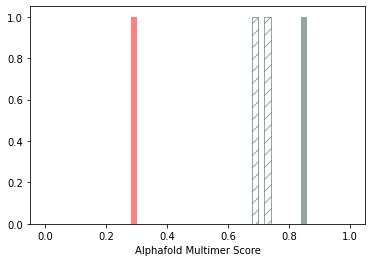

In [52]:
figuresModule.figS9_A(dfalphamulti_curated,fig = False, ax = False, save = False)
figuresModule.figS9_B(dfalphamulti_curated,fig = False, ax = False, save = False)
figuresModule.figS9_C(dfalphamulti_curated,fig = False, ax = False, save = False)

In [53]:
print( '\nComputation Time\n--------------------------')
get_computation_time(label = 'Protein Target Annotation Module', time_start=time_module_start)



Computation Time
--------------------------
Protein Target Annotation Module :  0.0m  6.7s


6.715495586395264

# Protein-To-Structures Module (#004A-C)
- <b>#004A</b> --  Match Structures to Protein Complexes, tradeoff in multi-structure vs single-structure matches
- <b>#004B</b> --  Build the quaternary structural proteome dataframe using sequence alignments
- <b>#004C</b> --  Ensure that chains in the structure files (.cif, .pdb, bioassembly.pdb, .etc) and chains in the PDB search APIs (.cifs) are consisent
<!-- - <b>#003D</b> --  QCQA Alphafold Multimer models  -->

In [54]:
#computation time
time_module_start = time.time()


In [55]:
#### Inputs Needed to Run #004A-C
# dfseq = op.join(qspace.DataOutputDir, '001D-dfrepseq.csv')
# dfseq = pd.read_csv(dfseq, index_col=0)


infile = op.join(qspace.DataOutput_dir, '003A-enzyme_targets_prior_to_BFS.csv')
proteinTargets = pd.read_csv(infile, index_col=0)

infile = op.join(qspace.DataOutput_dir, '003B-enzyme_targets_with_new_oligomers.csv')
proteinTargetsNew = pd.read_csv(infile, index_col=0)

enzymes = proteinTargets[proteinTargets.k_mer > 1]
print( "Number of Multimeric Enzymes (Old): ", len(enzymes))

enzymes = proteinTargetsNew[proteinTargetsNew.k_mer > 1]
print ("Number of Multimeric Enzymes (New): ", len(enzymes))


#PDB
infile = op.join(qspace.DataOutput_dir, '002D-best_structures_PDB.csv')
dfpseudo_pdb_best_needle = pd.read_csv(infile,index_col=0)
dfpseudo_pdb_best_needle['pdb_quality'] = pd.Series(dfpseudo_pdb_best_needle['pdb_quality_needle'])
# SWISS
infile = op.join(qspace.DataOutput_dir, '001F-best_structures_SWISS.csv')
dfpseudo_swiss_best = pd.read_csv(infile,index_col=0)

# ITASSER
infile = op.join(qspace.DataOutput_dir, '001F-best_structures_ITASSER.csv')
dfpseudo_itasser_best = pd.read_csv(infile,index_col=0)

# Alphafold
infile = op.join(qspace.DataOutput_dir, '001F-best_structures_ALPHAFOLD.csv')
dfpseudo_alphafold_best = pd.read_csv(infile,index_col=0)

# Alphafold Multimer
infile = op.join(qspace.DataOutput_dir, '003D-best_structures_AlphafoldMultimer.csv')
dfpseudo_alphaMulti_best = pd.read_csv(infile,index_col=0)


Number of Multimeric Enzymes (Old):  10
Number of Multimeric Enzymes (New):  16


##### 004A - Match protein complexes to structures

In [56]:
time_block_start = time.time()
dfbest = pd.DataFrame()
dfbest = dfbest.append(dfpseudo_pdb_best_needle)
dfbest = dfbest.append(dfpseudo_swiss_best)
dfbest = dfbest.append(dfpseudo_itasser_best)
dfbest = dfbest.append(dfpseudo_alphafold_best)
dfbest = dfbest.append(dfpseudo_alphaMulti_best)
outfile = op.join(qspace.DataOutput_dir, '003D-best_structures_ALL.csv')
dfbest.to_csv(outfile)                     
print ('Saving...\n\t> {}'.format(outfile))

quality_cutoff  = {'PDB': 70,'SWISS': 70,'ITASSER': 70,'ALPHAFOLD': 70, 'ALPHAFOLD_MULTIMER' : 0} #multimer results already checked,

data = pTSM.run_004A_get_matches(dfbest,
                                 proteinTargetsNew=proteinTargetsNew,
                                 quality_cutoff=quality_cutoff,
                                 remove_bad_structures = False,
                                )

Saving...
	> /home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/003D-best_structures_ALL.csv


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

<i> Run matching algorithm for protein complexes that cannot be represented accurately by protein structures in a 1:1 ratio</i> 

In [57]:
bfs_answers = pTSM.manual_bfs_answers
bfs_answers = pTSM.run_004A_MultiStructureMatching(to_bfs_filtered=data['BFSRequired'],
                                                   proteinTargetsNew=proteinTargetsNew,
                                                   dfbest=dfbest,
                                                   test_pyr  = True,
                                                   test_ribo = True,
                                                   bfs_answers = bfs_answers,
                                                  )


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

<i> Compare 1:1 matches vs subset matches (manuscript Figure 2.a.i) to find the best structural representation. Less structure files vs higher sequence identity trade off</i> 

In [58]:
dfmatch = pTSM.run_004A_GatherMatches(bfs_answers = bfs_answers,
                                      full_1_1 = data['FullMatch'],
                                      dfparent = proteinTargetsNew,
                                      dfbest = dfbest,
                                     )

dfmatch = pTSM.run_004A_rankMatches(dfmatch)

dfmatch_best = pTSM.run_004A_chooseBestMatch(dfmatch)
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '004A', time_start=time_block_start)
comp_time_data.update({'4A' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget



Computation Time
--------------------------
004A :  0.0m  10.1s


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

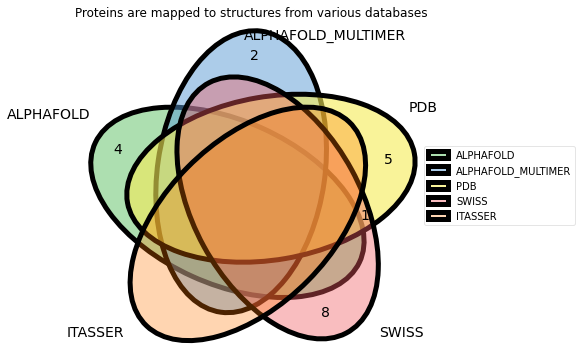

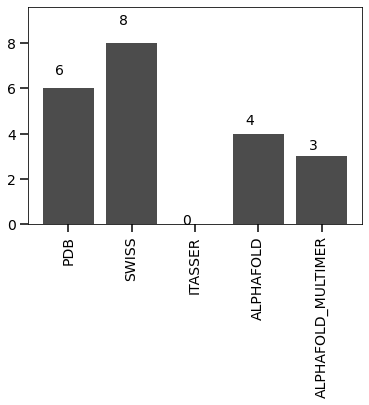

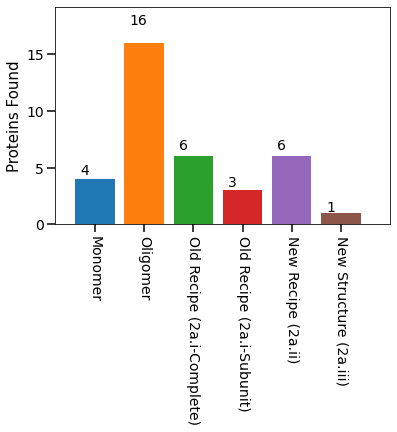

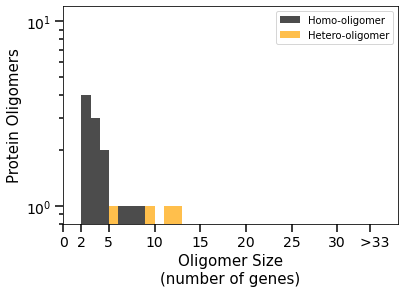

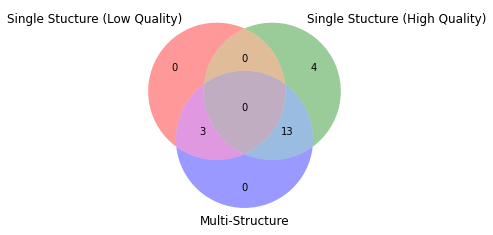

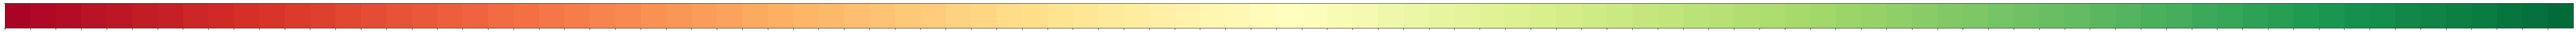

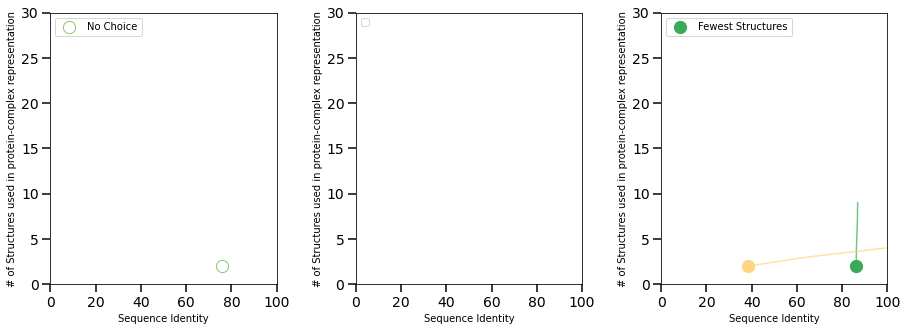

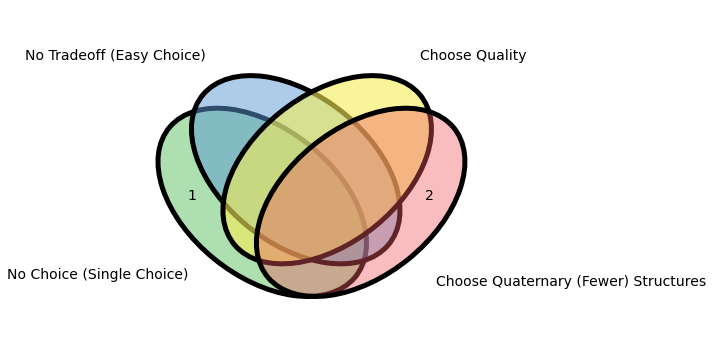

In [59]:
figuresModule.figS2(dfmatch_best,fig = False, ax = False, save = False)
figuresModule.fig2_B(dfmatch_best)
figuresModule.fig2_C(dfqual = dfmatch_best,
                    proteinTargetsOld = proteinTargets,
                    proteinTargetsNew = proteinTargetsNew,
                    )
figuresModule.fig2_D(dfqual = dfmatch_best,
                    proteinTargetsNew = proteinTargetsNew,
                    )
figuresModule.figS10_A(data)


dfmatch_for_supp = dfmatch[dfmatch.cplx.isin(bfs_answers)]
dfqual_for_supp = dfmatch_best[dfmatch_best.index.isin(bfs_answers)]
figuresModule.figS10_BE(dfmatch_for_supp=dfmatch_for_supp,dfqual_for_supp=dfqual_for_supp, save = False)

### 004B - Build the QSPACE

<i> Build the skeleton dataframe of the quaternary structural proteome atlas.</i> 

In [60]:
#inputs
dfmatch_best = pd.read_csv(op.join(qspace.DataOutput_dir,'004A-BFS_best_match_for_protein_complexes.csv'),index_col=0)
dfbest = pd.read_csv(op.join(qspace.DataOutput_dir,'003D-best_structures_ALL.csv'),index_col=0)
dfseq = pd.read_csv(op.join(qspace.DataOutput_dir,'001D-dfrepseq.csv'),index_col=0)

In [61]:
time_block_start = time.time()

dfQuatProteome = pTSM.run_004B_QuaternaryProteomeSkeleton(dfqual = dfmatch_best,
                                                          dfbest = dfbest,
                                                          dfrepseq = dfseq,

                                                         )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '004B', time_start=time_block_start)
comp_time_data.update({'4B' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget


INFO:_proteinToStructuresModule._004B_BuildQuaternaryProteome:Saving QSPACE proteome...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/004B-alldata_skeleton.csv

Computation Time
--------------------------
004B :  1.0m  0.6s


###### 004C - QCQA structures chains

<i> PDB API queries sometimes yield different chain-level information than what is actually in the downloaded structure file, leading to a discrepancy between PDB entities, PDB auth chains, and PDB asym chains. This module uses the chain-sequences to fix these errors and creates the sfileChain_residue column which contains the aa residue and aa chain that reflects the protein structure file.</i> 

In [62]:
#inputs
infile = op.join(qspace.DataOutput_dir, '004B-alldata_skeleton.csv') 
dfQuatProteome = pd.read_csv(infile, index_col = 0)

infile = op.join(qspace.DataOutput_dir, '002A-ALL_mapped_PDBS.csv') 
PDBchainSeqsAPI = pd.read_csv(infile,index_col=0)

In [63]:
time_block_start = time.time()
# missing_list = ['2vwt-assembly1','4dop-assembly1'] + dfQuatProteome.structureId.unique().tolist()[0:10]

# errlist = ['3srt-assembly1','1v58-assembly1','1rc2-assembly1','2vyc-assembly1','5vj1-assembly3','2scu-assembly1',]

dfallchains, dfallchains_w_seq,translation_dict= pTSM.run_004C_get_all_chains(dfalldata = dfQuatProteome,#[dfQuatProteome.structureId.isin(errlist)],
                                                                PDBchainSeqsAPI=PDBchainSeqsAPI,
                                                                force_rerun = True, # better to set to true to catch all newly mapped structures 
                                                               )

dfallchains.head()

Getting chains in structures vs chains in QSPACE dataframe...
-------------------------------------


A Jupyter Widget


INFO:_proteinToStructuresModule._004C_ConsistentChainIds:Saving dfChain-sfileChain map ...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/004C-structureFile_chains_mapped.csv
INFO:_proteinToStructuresModule._004C_ConsistentChainIds:Saving sfileChain AA seqs ...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/004C-structureFile_chain_seqs.csv
Finding exact matches to structure file chains...
-------------------------------------
Finding chain mismatches...
-------------------------------------
INFO:_proteinToStructuresModule._004C_ConsistentChainIds:Using structChainId chains 4ocg-assembly2 | Mismatched w/same chainId[0]
INFO:_proteinToStructuresModule._004C_ConsistentChainIds: 5o66-assembly1 addtional chains (i.e. antibody) | use subset structChain
Resolving chains in structures vs chains in QSPACE dataframe...
-------------------------------------


A Jupyter Widget


INFO:_proteinToStructuresModule._004C_ConsistentChainIds:Saving dfChain-sfileChain map ...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/004C-structureFile_chains_mapped.csv


,sfileChains,structChain,structChainId,structChainId_mod,use_reference,mismatch_reference,chain_translation
P75783_61_726_7uw5,"{D, C, F, B, G, E, A}","{C, D, F, B, G, E, A}","{C, D, F, B, G, E, A}","{C, D, F, B, G, E, A}",structChain,NaN,"{'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D', 'E': ..."
P21645_1_341_3eh0,"{B, C, A}","{B, A, C}","{B, A, C}","{B, A, C}",structChain,NaN,"{'A': 'A', 'B': 'B', 'C': 'C'}"
P36645_77_458_5zfr,"{D, C, F, B, E, A}","{C, D, F, B, E, A}","{C, D, F, B, E, A}","{C, D, F, B, E, A}",structChain,NaN,"{'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D', 'E': ..."
4ocg-assembly2,"{B-2, A-2, A-3, B-3, B, A}","{B, A}","{A-2, B-1, A-1, A-0, B-2, B-0}","{B, A}",NaN,structChainId,"{'A-0': 'A', 'A-1': 'A-2', 'A-2': 'A-3', 'B-0'..."
P27306_4_465_5u8v,"{B, A}","{B, A}","{B, A}","{B, A}",structChain,NaN,"{'A': 'A', 'B': 'B'}"


In [64]:
dfQuatProteome = pTSM.run_004C_global_chain_consistency(dfalldata=dfQuatProteome,
                                                        dfallchains=dfallchains,
                                                       )

print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '004C', time_start=time_block_start)
comp_time_data.update({'4C' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)


Mapping structureFileChainIds to QSPACE proteome.....
---------------------------------


A Jupyter Widget


Getting {structureFileChainId}_{Residue#}.....
---------------------------------


A Jupyter Widget


INFO:_proteinToStructuresModule._004C_ConsistentChainIds:Saving QSPACE proteome with chains fixed ...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/004C-alldata_skeleton.csv

Computation Time
--------------------------
004C :  0.0m  46.1s


##### Fig 1E 

In [65]:
#inputs
infile = op.join(qspace.DataOutput_dir, '004C-alldata_skeleton.csv')
dfQuatProteome = pd.read_csv(infile, index_col=0)
figuresModule.fig1_E(dfskeleton = dfQuatProteome)


Number of Genes       : 24
Number of Enzymes     : 20
Number of Structures  : 21
Number of Amino Acids : 39958
Number of Genome Positions : 10292


##### Fig 1F

A Jupyter Widget

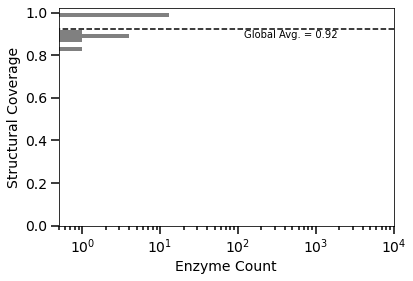

In [66]:
infile = op.join(qspace.DataOutput_dir, '004C-alldata_skeleton.csv')
dfQuatProteome = pd.read_csv(infile, index_col=0)
fig, ax =figuresModule.fig1_F(dfskeleton = dfQuatProteome)
plt.show()

In [67]:
print( '\nComputation Time\n--------------------------')
get_computation_time(label = 'Proteins to Structures Module', time_start=time_module_start)



Computation Time
--------------------------
Proteins to Structures Module :  2.0m  11.8s


131.7654378414154

# Membrane Module (#005A-F)
- <b>#005A</b> --  Identify membrane structures from EcoCyc, GO, Uniprot, IML1515
- <b>#005B</b> --  Write .pdb files for identified structures (to send to OPM)
- <b>#005C</b> --  Run OPM server, download results
- <b>#005D1</b> --  Calculate membrane planes from OPM
- <b>#005D2</b> --  Calculate membrane planes from UniProt
- <b>#005D3</b> --  Calculate membrane planes from DeepTMHMM
- <b>#005E</b> --  QCQA membrane planes
- <b>#005F</b> --  assign sub-cellular compartment with AA-level detail


<!-- - <b>#003D</b> --  QCQA Alphafold Multimer models  -->

In [68]:
#computation time
time_module_start = time.time()


In [69]:
#### inputs needed for membrane module
dfseq = op.join(qspace.DataOutput_dir, '001D-dfrepseq.csv')
dfseq = pd.read_csv(dfseq, index_col=0)

infile = op.join(qspace.DataOutput_dir, '004C-alldata_skeleton.csv')
dfQuatProteome = pd.read_csv(infile, index_col=0)

infile = op.join(qspace.DataOutput_dir, '003D-best_structures_ALL.csv')
dfbest_structures = pd.read_csv(infile, index_col=0)

##### 005A - find all potential membrane structures

<i>Determine which proteins are potential membrane structures using the gene-level annotations provided in uniprot, ecocyc, iml1515, and gene-ontology</i>

In [70]:
#inputs 
time_block_start = time.time()
dfecocyc_loc = pd.read_csv(op.join(qspace.Input_dir, "005A-EcocycSmartTable-All-genes-of-E.-coli-K-12-substr.-MG1655.txt"),sep = '\t')
dfiml1515= pd.read_csv(op.join(qspace.Input_dir, "005A-iML1515_GP_subsystems_nbt.3956-S7.csv"))

potentialMembraneStructures, potentialMembraneData = membraneModule.run_005A_IdentifyMembrane(dfrepseq = dfseq,
                                                                             dfiml1515=dfiml1515,
                                                                             dfall = dfQuatProteome[dfQuatProteome.sfileChain_Residue.isna() == False],
                                                                             dfecocyc_loc = dfecocyc_loc,
                                                                             uniprotSequenceDir = qspace.UniprotSeqsDir,
                                                                            )
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '005A', time_start=time_block_start)
comp_time_data.update({'5A' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)
    
with open (op.join(qspace.DataOutput_dir, "005A_potentialMembraneStructuresAllSources.json"),'w' ) as f:
    json.dump(potentialMembraneData,f)

Finding all potential membrane structures...
----------------------------------


A Jupyter Widget

A Jupyter Widget


INFO:_membraneModule.utils:Saving membrane genes identified from iML1515 keyword search...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005A-membrane_kw_IML1515_terms.json


A Jupyter Widget


INFO:_membraneModule.utils:Saving membrane structures identified from uniprot keyword search...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005A-membrane_kw_UniProt_terms.json


A Jupyter Widget


INFO:_membraneModule.utils:Saving membrane structures identified from Ecocyc keyword search...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005A-membrane_kw_Ecocyc_terms.json
INFO:_membraneModule._005A_identifyMembraneStructures:Saving potential membrane structures......
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005A-potential_membrane_structures.json

Computation Time
--------------------------
005A :  0.0m  4.3s


##### 005B - prep structures for OPM

<i>OPM works with PDB files. We write out .cif files into .pdb files and save them in qspace.opmStructuresToSendDir. If chains differ between .cif and opm.pdb files, we keep track of these</i>

In [71]:
infile = op.join(qspace.DataOutput_dir, '005A-potential_membrane_structures.json')
with open(infile, 'r') as f:
    potentialMembraneStructures = json.load(f)

In [73]:
time_block_start = time.time()
structureFileLocations,opmChains = membraneModule.run_005B_writeOPMpdbs(potential_membrane_structures=potentialMembraneStructures,
                                                                  outfolder = qspace.opmStructuresToSendDir,
                                                                  force_rerun= True,
                                                                 )
sfileDict = structureFileLocations.sfile.to_dict()
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '005B', time_start=time_block_start)
comp_time_data.update({'5B' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget


INFO:_membraneModule._005B_prepStructuresForOPM:Saving OPM chain translation ....
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005B-structChain_opmChain.json

Computation Time
--------------------------
005B :  0.0m  12.3s


##### 005C - Send PDB files to OPM

<i>This module uses selenium to upload pdb files to OPM, wait for and download results. It defaults to using previously calculations, please do not force it to re-caclulcate membrane integration for the same set of PDB structures more than once.</i>

In [75]:
errorsOPM = []

In [76]:
structureFileLocations = pd.read_csv(op.join(qspace.DataOutput_dir,'005B-opmStructureLocations.csv'),index_col = 0 )
structureFileLocations.head()


,stype,sfile,to_opm_file,origChain_opmChain
P0A6A3_1_400_3slc,SWISS,../../../../../../../mnt/wwn-0x5000c500b96b98e...,../../../../../../../mnt/wwn-0x5000c500b96b98e...,same_as_pdb
ABC-26-CPLX_AlphaMulti,ALPHAFOLD_MULTIMER,/home/ecatoiu/Projects/QSPACE_install/QSPACE/D...,../../../../../../../mnt/wwn-0x5000c500b96b98e...,same_as_pdb
b3241_6__AlphaMulti,ALPHAFOLD_MULTIMER,/home/ecatoiu/Projects/QSPACE_install/QSPACE/D...,../../../../../../../mnt/wwn-0x5000c500b96b98e...,same_as_pdb
b3240_3__AlphaMulti,ALPHAFOLD_MULTIMER,/home/ecatoiu/Projects/QSPACE_install/QSPACE/D...,../../../../../../../mnt/wwn-0x5000c500b96b98e...,same_as_pdb
P36645_77_458_5zfr,SWISS,../../../../../../../mnt/wwn-0x5000c500b96b98e...,../../../../../../../mnt/wwn-0x5000c500b96b98e...,same_as_pdb


In [78]:
#works with selenium==3.14.0
time_block_start = time.time()

errorsOPM,not_solved_dict = membraneModule.run_005C_opmServer(query_structureIds = structureFileLocations.index.tolist(),
                                                              pdbOutputs = {},
                                                              htmlOutputs = {},
                                                              not_solved_dict = {},
                                                              force_rerun = False,
                                                              to_opm_PDBfolder = qspace.opmStructuresToSendDir ,
                                                              from_opm_PDBfolder = qspace.opmOutputStructuresDir ,
                                                              errorsOPM = [],
                                                              chromeDriverLocation = path_to_chromedriver, #set up in beginning
                                                              OPMdataFolder = qspace.opmOutputDataDir,
                                                             )


2 of 10 still need OPM


A Jupyter Widget


 P75783_61_726_7uw5
https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_024902537_5805566%2Fppm_results.html
................
 6wxi-assembly1
https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_025104043_9765766%2Fppm_results.html
................


If you notice that OPM gets stuck on a specific structure (i.e. it got to the results page but there is not PDB file output. <b><u>NOTE: this is not the same thing as a pending calculation.</u></b>), then the following block will run forever, checking for a LINK to the PDB file that will never manifest. If this happens (not common), just remove the structure id causing the issue from the "not_solved_dict" and try again until all pending structures are solved.  

In [79]:
#not_solved_dict = {}

while len(not_solved_dict) > 0:
    not_solved_dict = membraneModule.run_005C_goBackandCheck(not_solved_dict,
                                              to_opm_folder = qspace.opmStructuresToSendDir ,
                                              from_opm_PDBfolder = qspace.opmOutputStructuresDir,
                                              force_rerun = False,
                                              OPMdataFolder = qspace.opmOutputDataDir,
                                              chromeDriverLocation =  path_to_chromedriver, #set up in beginning
                                             )
    
    time.sleep(30)
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '005C', time_start=time_block_start)
comp_time_data.update({'5C' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget


 P75783_61_726_7uw5

 https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_024902537_5805566%2Fppm_results.html
......


A Jupyter Widget


 P75783_61_726_7uw5

 https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_024902537_5805566%2Fppm_results.html
......


A Jupyter Widget


 P75783_61_726_7uw5

 https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_024902537_5805566%2Fppm_results.html
......


A Jupyter Widget


 P75783_61_726_7uw5

 https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_024902537_5805566%2Fppm_results.html
......


A Jupyter Widget


 P75783_61_726_7uw5

 https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_024902537_5805566%2Fppm_results.html
......


A Jupyter Widget


 P75783_61_726_7uw5

 https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_024902537_5805566%2Fppm_results.html
......


A Jupyter Widget


 P75783_61_726_7uw5

 https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_024902537_5805566%2Fppm_results.html
......


A Jupyter Widget


 P75783_61_726_7uw5

 https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_024902537_5805566%2Fppm_results.html
......


A Jupyter Widget


 P75783_61_726_7uw5

 https://lomize-common.s3.us-east-2.amazonaws.com/waiting.html?results=https%3A%2F%2Fppm-results.s3.us-east-2.amazonaws.com%2F20230519_024902537_5805566%2Fppm_results.html
......

Computation Time
--------------------------
005C :  20.0m  24.2s


##### 005D1 - opm membrane calculation

<i>Calculate membrane planes from OPM results</i>

In [80]:
time_block_start = time.time()

planes_dict, checked = membraneModule.run_005D1_opmPlanes(potential_membrane_structures=potentialMembraneStructures,
                                                         OPMstructureFolder = qspace.opmOutputStructuresDir,
                                                         force_rerun = force_rerun_global,
                                                         OPMJsonFolder = qspace.opmOutputDataDir,
                                                         OPMcsvFolder = qspace.opmCsvDir,
                                                         checked = []
                                                        )
dfmembrane_opm = membraneModule.run_005D1_membraneQCQA(planes_dict, query = 'OPM')
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '005D1', time_start=time_block_start)
comp_time_data.update({'5D1' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Getting OPM membrane data ...
------------------------------------------------
Num AAs 	 structureId 	 N-leaf AAs 	 O-leaf AAs 	 Label


A Jupyter Widget

798 	 P0A6A3_1_400_3slc 	 51 	 0 	 Associated
1838 	 ABC-26-CPLX_AlphaMulti 	 51 	 51 	 Membrane


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


1860 	 b3241_6__AlphaMulti 	 51 	 51 	 Membrane


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


1965 	 b3240_3__AlphaMulti 	 51 	 51 	 Membrane


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


2286 	 P36645_77_458_5zfr 	 51 	 0 	 Associated
6544 	 5o66-assembly1 	 51 	 51 	 Membrane


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


4662 	 P75783_61_726_7uw5 	 51 	 51 	 Membrane


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


250 	 AF-P77599-F1-model_v2 	 51 	 51 	 Membrane


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


4582 	 5nik-assembly1 	 51 	 51 	 Membrane


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


1284 	 6wxi-assembly1 	 51 	 51 	 Membrane


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)



INFO:_membraneModule.utils:Saving membrane planes dictionary...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005D-MembranePlanesOPM.json
Setting up membrane QCQA and calculating angle between planes ...
------------------------------------------------
Area and thickness membrane QCQA ...
------------------------------------------------


A Jupyter Widget


INFO:_membraneModule.utils:Saving membrane calculations...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005D1-OPM_membrane_data.csv

Computation Time
--------------------------
005D1 :  1.0m  29.5s


##### 005D2 - uniprot membrane calculation

<i>Calculate membrane planes from Uniprot Annotations</i>

In [81]:
structureFileLocations = pd.read_csv(op.join(qspace.DataOutput_dir,'005B-opmStructureLocations.csv'),index_col = 0 )
structureFileLocations.head()

,stype,sfile,to_opm_file,origChain_opmChain
P0A6A3_1_400_3slc,SWISS,../../../../../../../mnt/wwn-0x5000c500b96b98e...,../../../../../../../mnt/wwn-0x5000c500b96b98e...,same_as_pdb
ABC-26-CPLX_AlphaMulti,ALPHAFOLD_MULTIMER,/home/ecatoiu/Projects/QSPACE_install/QSPACE/D...,../../../../../../../mnt/wwn-0x5000c500b96b98e...,same_as_pdb
b3241_6__AlphaMulti,ALPHAFOLD_MULTIMER,/home/ecatoiu/Projects/QSPACE_install/QSPACE/D...,../../../../../../../mnt/wwn-0x5000c500b96b98e...,same_as_pdb
b3240_3__AlphaMulti,ALPHAFOLD_MULTIMER,/home/ecatoiu/Projects/QSPACE_install/QSPACE/D...,../../../../../../../mnt/wwn-0x5000c500b96b98e...,same_as_pdb
P36645_77_458_5zfr,SWISS,../../../../../../../mnt/wwn-0x5000c500b96b98e...,../../../../../../../mnt/wwn-0x5000c500b96b98e...,same_as_pdb


In [82]:
time_block_start = time.time()
potential_membrane_complex = dfQuatProteome[dfQuatProteome.structureId.isin(potentialMembraneStructures)].cplx.unique().tolist()

dfmembrane_residues_uniprot = membraneModule.run_005D2_uniprotResidues(potential_membrane_structures=potentialMembraneStructures,
                                                                     potential_membrane_complex=potential_membrane_complex,
                                                                     dfalldata = dfQuatProteome,                                                                     
                                                                    )

A Jupyter Widget

A Jupyter Widget


INFO:_membraneModule.utils:Saving membrane residues dataframe ...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005D2-MembraneResiduesUniProt.json


In [83]:
dfmembrane_residues_uniprot = membraneModule.fix_for_ecoli_proteome(dfmembrane_residues_uniprot)
sfileDict = structureFileLocations.sfile.to_dict()

Fixing specific Uniprot residues in E.coli....
	> /home/ecatoiu/Projects/QSPACE_install/QSPACE/_membraneModule/manualFix_UniProtresidues.json


In [84]:
planes_dict = membraneModule.run_005D2_uniprotPlanes(dfmembrane_residues_uniprot=dfmembrane_residues_uniprot,
                                                     sfileDict=sfileDict)

A Jupyter Widget

INFO:_membraneModule.utils:CPLX0-7983
INFO:_membraneModule.utils:P75783_61_726_7uw5
INFO:_membraneModule.utils:../../../../../../../mnt/wwn-0x5000c500b96b98e1-part1/QSPACE_install/structures/all_swiss/P75783_61_726_7uw5.pdb
INFO:_membraneModule.utils:TM_2
INFO:_membraneModule.utils:TM_1
INFO:_membraneModule.utils:ABC-26-CPLX
INFO:_membraneModule.utils:ABC-26-CPLX_AlphaMulti
INFO:_membraneModule.utils:/home/ecatoiu/Projects/QSPACE_install/QSPACE/Demo_Results/AFMstructures/ABC-26-CPLX.result/ABC-26-CPLX_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
INFO:_membraneModule.utils:Cytoplasmic
INFO:_membraneModule.utils:Periplasmic_C
INFO:_membraneModule.utils:CPLX0-4
INFO:_membraneModule.utils:b3241_6__AlphaMulti
INFO:_membraneModule.utils:/home/ecatoiu/Projects/QSPACE_install/QSPACE/Demo_Results/AFMstructures/b3241_6_.result/b3241_6__unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
INFO:_membraneModule.utils:TM_2
INFO:_membraneModule.utils:TM_1
INFO:_membraneMod

In [85]:
dfmembrane_uniprot = membraneModule.run_005D2_membraneQCQA(planes_dict=planes_dict, 
                                                           sfileDict=sfileDict,
                                                           query = 'Uniprot', 
                                                           dfmembrane_residues_uniprot=dfmembrane_residues_uniprot,
                                                           csvFolder =  qspace.UniprotCsvDir,
                                                          )
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '005D2', time_start=time_block_start)
comp_time_data.update({'5D2' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Setting up membrane QCQA and calculating angle between planes ...
------------------------------------------------
Area and thickness membrane QCQA ...
------------------------------------------------


A Jupyter Widget


INFO:_membraneModule.utils:Saving membrane calculations...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005D2-Uniprot_membrane_data.csv
INFO:_membraneModule.utils:Saving membrane calculations...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005D2-Uniprot_membrane_data.csv

Computation Time
--------------------------
005D2 :  1.0m  52.9s


##### 005D3 tmhmmm membrane calculation


<i>Write file to send to deepTMHMM. 
    
File is located at qspace.DataOutput_dir + ProjectName/ + 005D3-to_TMHMM_server.txt</i>

In [86]:
time_block_start = time.time()
#inputs
infile = op.join(qspace.DataOutput_dir, '005A-potential_membrane_structures.json')
with open(infile, 'r') as f:
    potentialMembraneStructures = json.load(f)
    
potential_membrane_complex = dfQuatProteome[dfQuatProteome.structureId.isin(potentialMembraneStructures)].cplx.unique().tolist()

#run
membraneModule.run_005D3_write_tmhmm_file(potential_membrane_complex= potential_membrane_complex,
                                          dfalldata = dfQuatProteome,
                                         force_rerun = force_rerun_global)



A Jupyter Widget


SEND FILE : /home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005D3-to_TMHMM_server.txt to https://dtu.biolib.com/DeepTMHMM.
May need to break it down into smaller files for DTU server


In demo mode, this is done for you...

<i>Send the file "005D3-to_TMHMM_server.txt" to https://dtu.biolib.com/DeepTMHMM.
    
DeepTMHMM may require that you break the file up into smaller chunks. 
    
Download the .3line results into QSPACE/005D3-TMHMM_results/ </i>

##### Then...

<i> Determine membrane-crossing residues from TMHMM results </i>


In [87]:
dfmembrane_residues_tmhmm = membraneModule.run_005D3_tmhmmResidues(tmhmmFolder = qspace.tmhmmResultsDir,
                                                                   dfalldata = dfQuatProteome)

Reading deepTMHMM results....
-----------------------------------------


A Jupyter Widget

/home/ecatoiu/Projects/QSPACE_install/QSPACE/005D3-TMHMM_results/predicted_topologies_6075.3line


A Jupyter Widget


/home/ecatoiu/Projects/QSPACE_install/QSPACE/005D3-TMHMM_results/predicted_topologies_1530.3line


A Jupyter Widget


/home/ecatoiu/Projects/QSPACE_install/QSPACE/005D3-TMHMM_results/predicted_topologies_4560.3line


A Jupyter Widget


/home/ecatoiu/Projects/QSPACE_install/QSPACE/005D3-TMHMM_results/predicted_topologies_7590.3line


A Jupyter Widget


/home/ecatoiu/Projects/QSPACE_install/QSPACE/005D3-TMHMM_results/predicted_topologies_0015.3line


A Jupyter Widget


/home/ecatoiu/Projects/QSPACE_install/QSPACE/005D3-TMHMM_results/predicted_topologies_3045.3line


A Jupyter Widget



Adding Gene-Chain-Structure-Uniprot-Leaf information....
-----------------------------------------


A Jupyter Widget


Adding structure residues numbers....
-----------------------------------------


A Jupyter Widget

##### And ...
<i> Calculate membrane planes from TMHMM results </i>

In [88]:


#inputs
dfmembrane_residues_tmhmm = pd.read_csv(op.join(qspace.DataOutput_dir, '005D3-MembraneResiduesTMHMM.csv'),index_col=0)
structureFileLocations = pd.read_csv(op.join(qspace.DataOutput_dir,'005B-opmStructureLocations.csv'),index_col = 0 )
sfileDict = structureFileLocations.sfile.to_dict()

#run
planes_dict = membraneModule.run_005D3_tmhmmPlanes(dfmembrane_residues_tmhmm=dfmembrane_residues_tmhmm,
                                                   sfileDict=sfileDict,
                                                   dfalldata = dfQuatProteome,
                                                  )

dfmembrane_tmhmm = membraneModule.run_005D3_membraneQCQA(planes_dict=planes_dict, 
                                                         sfileDict=sfileDict,
                                                         query = 'TMHMM', 
                                                         csvFolder =  qspace.TMHMMcsvDir,
                                                         dfalldata = dfQuatProteome,
                                                        )
print( '\nComputation Time\n--------------------------')
time_point = get_computation_time(label = '005D3', time_start=time_block_start)
comp_time_data.update({'5D3' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget


Setting up membrane QCQA and calculating angle between planes ...
------------------------------------------------


A Jupyter Widget


Area and thickness membrane QCQA ...
------------------------------------------------


A Jupyter Widget


INFO:_membraneModule.utils:Saving membrane calculations...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005D3-TMHMM_membrane_data.csv

Computation Time
--------------------------
005D3 :  0.0m  47.9s


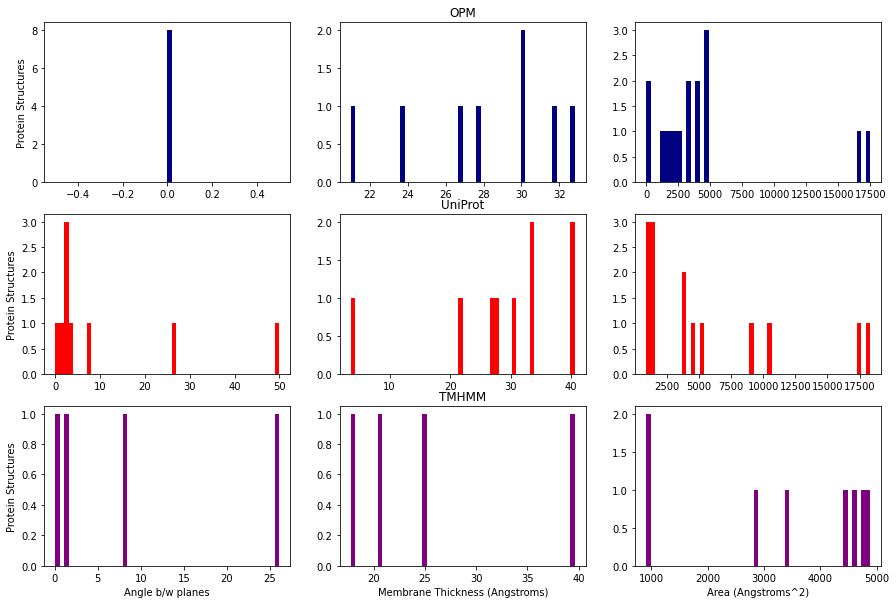

In [89]:
#inputs
dfmembrane_opm = pd.read_csv(op.join(qspace.DataOutput_dir, '005D1-OPM_membrane_data.csv'), index_col=0)
dfmembrane_uniprot = pd.read_csv(op.join(qspace.DataOutput_dir, '005D2-Uniprot_membrane_data.csv'), index_col=0)
dfmembrane_tmhmm = pd.read_csv(op.join(qspace.DataOutput_dir, '005D3-TMHMM_membrane_data.csv'), index_col=0)

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(3,3)
fig.set_figwidth(15)
fig.set_figheight(10)


data = dfmembrane_opm
i = 0 
color= 'navy'
ax[i][0].hist(data.angle.values, bins = 50, color = color)
# ax[i][0].set_xlabel('Angle b/w planes')
ax[i][1].hist(data.membrane_thickness.values, bins = 50, color = color)
# ax[i][1].set_xlabel('Membrane Thickness (Angstroms)')
ax[i][1].set_title("OPM")

areas = []
for index, row in data.iterrows():
    for leaf, area in ast.literal_eval(row.embedded_area).items():
        areas += [area]
n, bins, plot= ax[i][2].hist(areas, bins = 50, color = color)
# ax[i][2].set_xlabel('Area (Angstroms^2)')

data = dfmembrane_uniprot
i = 1
color= 'red'
ax[i][0].hist(data.angle.values, bins = 50, color = color)
# ax[i][0].set_xlabel('Angle b/w planes')
ax[i][1].hist(data.membrane_thickness.values, bins = 50, color = color)
# ax[i][1].set_xlabel('Membrane Thickness (Angstroms)')
ax[i][1].set_title("UniProt")

areas = []
for index, row in data.iterrows():
    for leaf, area in ast.literal_eval(row.embedded_area).items():
        areas += [area]
n, bins, plot= ax[i][2].hist(areas, bins = 50, color = color)
# ax[i][2].set_xlabel('Area (Angstroms^2)')
data = dfmembrane_tmhmm
i = 2
color= 'purple'
ax[i][0].hist(data.angle.values, bins = 50, color = color)
ax[i][0].set_xlabel('Angle b/w planes')
ax[i][1].hist(data.membrane_thickness.values, bins = 50, color = color)
ax[i][1].set_xlabel('Membrane Thickness (Angstroms)')
ax[i][1].set_title("TMHMM")

areas = []
for index, row in data.iterrows():
    for leaf, area in ast.literal_eval(row.embedded_area).items():
        areas += [area]
n, bins, plot= ax[i][2].hist(areas, bins = 50, color = color)
ax[i][2].set_xlabel('Area (Angstroms^2)')

for i in [0,1,2]:
    ax[i][0].set_ylabel('Protein Structures')


##### 005E QCQA membrane calculations from OPM/Uniprot/DeepTMHMM

In [90]:
#### imports needed for #005E

structureFileLocations = pd.read_csv(op.join(qspace.DataOutput_dir, '005B-opmStructureLocations.csv'), index_col = 0 )
structureOPMChains= structureFileLocations[structureFileLocations.origChain_opmChain != 'same_as_pdb'].origChain_opmChain.to_dict()
# structureOPMChains = opmChains

dfmembrane_opm = pd.read_csv(op.join(qspace.DataOutput_dir, '005D1-OPM_membrane_data.csv'), index_col=0)
dfmembrane_uniprot = pd.read_csv(op.join(qspace.DataOutput_dir, '005D2-Uniprot_membrane_data.csv'), index_col=0)
dfmembrane_tmhmm = pd.read_csv(op.join(qspace.DataOutput_dir, '005D3-TMHMM_membrane_data.csv'), index_col=0)

membrane_calculations = {"OPM":dfmembrane_opm, "Uniprot":dfmembrane_uniprot, "TMHMM":dfmembrane_tmhmm}

infile = op.join(qspace.DataOutput_dir, '004C-alldata_skeleton.csv')
dfQuatProteome = pd.read_csv(infile, index_col=0)

dfseq = op.join(qspace.DataOutput_dir, '001D-dfrepseq.csv')
dfseq = pd.read_csv(dfseq, index_col=0)


In [91]:
time_block_start = time.time()

membrane_calculations,dfsource = membraneModule.run_005E_combineMembraneData(membrane_calculations=membrane_calculations,
                                                                                      )
sharedDict = membraneModule.run_005E_UniOPMshared_bulbs(dfsource,structureOPMChains)
dfsource, dfmissing = membraneModule.run_005E_auto_orient(sharedDict,dfsource)

leaf_translation_failedQCQA = {"AF-P02929-F1-model_v2" :{'O': 'Periplasmic_C', 'N': 'Cytoplasmic'},
                               "AF-P45762-F1-model_v2" : {'O': 'Periplasmic_C', 'N': 'Cytoplasmic'},
                               'AF-P0AAE8-F1-model_v2' : {'O': 'Periplasmic_C', 'N': 'Cytoplasmic'},
                              }

missingleaves = {'AF-P02929-F1-model_v2' : ['Extracellular'],
                 'AF-P45762-F1-model_v2' : ['Cytoplasmic'],
                }

Finding shared residues between OPM and UniProt bulbs
--------------------------------------


A Jupyter Widget

A Jupyter Widget


INFO:_membraneModule._005E_qcqaMembrane:Saving membrane calculations for QCQA'd proteins...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005E-QCQA_dfsource.csv


In [92]:
dfsource, dfsourceNeedsManualCuration = membraneModule.run_005E_gapFillMissingTopoDomains(dfsource=dfsource,
                                                                                          dfmissing=dfmissing,
                                                                                          dfalldata = dfQuatProteome[dfQuatProteome.sfileChain_Residue.isna() == False],
                                                                                          missingleaves=missingleaves,
                                                                                          structureOPMChains=structureOPMChains,
                                                                                          leaf_translation_failedQCQA= leaf_translation_failedQCQA,
                                                                                         )

A Jupyter Widget

INFO:_membraneModule._005E_qcqaMembrane:AF-P77599-F1-model_v2
INFO:_membraneModule._005E_qcqaMembrane:P77599
INFO:_membraneModule._005E_qcqaMembrane:A
INFO:_membraneModule._005E_qcqaMembrane:b2336
INFO:_membraneModule._005E_qcqaMembrane:ABC-26-CPLX_AlphaMulti
INFO:_membraneModule._005E_qcqaMembrane:P14175
INFO:_membraneModule._005E_qcqaMembrane:A
INFO:_membraneModule._005E_qcqaMembrane:b2677
INFO:_membraneModule._005E_qcqaMembrane:B
INFO:_membraneModule._005E_qcqaMembrane:b2677
INFO:_membraneModule._005E_qcqaMembrane:P14176
INFO:_membraneModule._005E_qcqaMembrane:C
INFO:_membraneModule._005E_qcqaMembrane:b2678
INFO:_membraneModule._005E_qcqaMembrane:D
INFO:_membraneModule._005E_qcqaMembrane:b2678
INFO:_membraneModule._005E_qcqaMembrane:P0AFM2
INFO:_membraneModule._005E_qcqaMembrane:E
INFO:_membraneModule._005E_qcqaMembrane:b2679
INFO:_membraneModule._005E_qcqaMembrane:b3241_6__AlphaMulti
INFO:_membraneModule._005E_qcqaMembrane:P46482
INFO:_membraneModule._005E_qcqaMembrane:A
INFO:_memb

In [93]:
dfsource,dfsource_final = membraneModule.run_005E_useManualOrient(dfsource = dfsource,
                                                                  dfuni = dfmembrane_uniprot, 
                                                                  dftmhmm = dfmembrane_tmhmm,
                                                                  membrane_calculations=membrane_calculations, 
                                                                  base = qspace.opmManualOrientDir
                                                                 )

global_orientation_dict,global_embedded_dict= membraneModule.run_005E_mapOrientationToProteome(dforientation=dfsource_final,
                                                                                               dfalldata= dfQuatProteome,
                                                                                               structureOPMChains=structureOPMChains,
                                                                                               OPMcsvFolder = qspace.opmCsvDir,
                                                                                               UniprotcsvFolder = qspace.UniprotCsvDir,
                                                                                               TMHMMcsvFolder = qspace.TMHMMcsvDir,
                                                                                              )

print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '005E', time_start=time_block_start)
comp_time_data.update({'5E' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

INFO:_membraneModule._005E_qcqaMembrane:Saving membrane leaf orienation and sources of membrane information...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005E-membrane_leaves_and_sources.csv


A Jupyter Widget

A Jupyter Widget


INFO:_membraneModule._005E_qcqaMembrane:Saving AA-level membrane orientation ...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005E2-StructuralProteome_membrane_orientation.json
INFO:_membraneModule._005E_qcqaMembrane:Saving AA-level membrane embeddedness ...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005E2-StructuralProteome_membrane_embeddedness.json

Computation Time
--------------------------
005E :  0.0m  2.3s


##### 005F - Assign Cellular Compartments to QSPACE dataframe

In [94]:
time_block_start = time.time()
dfnonMembraneOrientation = membraneModule.run_005F_assignCompartmentsEcocycAndGO(dfalldata = dfQuatProteome,
                                                                      global_embedded_dict=global_embedded_dict,
                                                                      global_orientation_dict=global_orientation_dict,
                                                                      dfrepseq = dfseq,
                                                                      ecocyc_file = op.join(qspace.Input_dir, '005A-EcocycSmartTable-All-genes-of-E.-coli-K-12-substr.-MG1655.txt'),        
                                                                     )
dfnonMembraneOrientation = membraneModule.run_005F_addComparmentsManually(dfnonMembraneOrientation,
                                                               manualOrientFile = op.join(qspace.Input_dir,'005F-ManualCompartmentsForNonMembraneStructures.csv'),
                                                               
                                                              )

proteinCompartment, aminoCompartment_dict,dfcompartments = membraneModule.run_005F_assignAALevelLocation(dforientation=dfnonMembraneOrientation,
                                                                                                         dfalldata = dfQuatProteome,
                                                                                                         data_int_orient=global_orientation_dict,
                                                                                                         data_int_embed=global_embedded_dict,
                                                                                                        )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '005F', time_start=time_block_start)
comp_time_data.update({'5F' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


INFO:_membraneModule.utils:Saving Manual orientation of Proteins dataframe...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005F-df_orientation_after_manual_curation.csv


A Jupyter Widget


Assigning AA Compartments.....
----------------------
INFO:_membraneModule.utils:Saving QSPACE Proteome - AA-level compartments...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005F-StructuralProteome_AA_compartment.json


A Jupyter Widget

A Jupyter Widget


INFO:_membraneModule.utils:Saving QSPACE Proteome - Proteome-level compartments...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/005F-StructuralProteome_Protein_compartment.json

Computation Time
--------------------------
005F :  0.0m  1.2s


In [95]:
print( '\nComputation Time\n--------------------------')
get_computation_time(label = 'Membrane / Subcellular Compartment Module', time_start=time_module_start)



Computation Time
--------------------------
Membrane / Subcellular Compartment Module :  35.0m  42.8s


2142.7694318294525

# Structural Properties (#006A-F)
- <b>#006A</b> --  Disordered regions.  
- <b>#006B</b> --  SCRATCH. 
- <b>#006C</b> --  MS/MS
- <b>#006D</b> --  Disulfide bridges
- <b>#006E</b> --  protein-protein interfaces. 
- <b>#006F</b> --  DSSP

Needs DisEMBL: http://dis.embl.de/

Needs SCRATCH : https://scratch.proteomics.ics.uci.edu/

Needs ScanNet : https://github.com/jertubiana/ScanNet

In [7]:
#computation time
time_module_start = time.time()
time_block_start = time.time()

In [8]:
#### imports needed for #006

structureFileLocations = pd.read_csv(op.join(qspace.DataOutput_dir, '005B-opmStructureLocations.csv'), index_col = 0 )
structureOPMChains= structureFileLocations[structureFileLocations.origChain_opmChain != 'same_as_pdb'].origChain_opmChain.to_dict()
# structureOPMChains = opmChains

dfmembrane_opm = pd.read_csv(op.join(qspace.DataOutput_dir, '005D1-OPM_membrane_data.csv'), index_col=0)
dfmembrane_uniprot = pd.read_csv(op.join(qspace.DataOutput_dir, '005D2-Uniprot_membrane_data.csv'), index_col=0)
dfmembrane_tmhmm = pd.read_csv(op.join(qspace.DataOutput_dir, '005D3-TMHMM_membrane_data.csv'), index_col=0)

membrane_calculations = {"OPM":dfmembrane_opm, "Uniprot":dfmembrane_uniprot, "TMHMM":dfmembrane_tmhmm}

infile = op.join(qspace.DataOutput_dir, '004C-alldata_skeleton.csv')
dfQuatProteome = pd.read_csv(infile, index_col=0)

dfseq = op.join(qspace.DataOutput_dir, '001D-dfrepseq.csv')
dfseq = pd.read_csv(dfseq, index_col=0)

##### 006A

In [26]:
disembl_cmd = '/home/ecatoiu/Downloads/DisEMBL-1.4/DisEMBL.py'


In [27]:
time_block_start = time.time()
##### Fasta File Locations
dfFastaLoc = structuralPropUtils.get_fastaFileLocations(dfalldata = dfQuatProteome)
df_disemble,  disemble_global_info = structuralPropertiesModule.run_006A_Disembl(dfalldata = dfQuatProteome ,
                                                                            disembl_cmd = disembl_cmd,
                                                                          dfFastaLoc = dfFastaLoc)
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '006A', time_start=time_block_start)
comp_time_data.update({'6A' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget


Running DisEMBL...


A Jupyter Widget


INFO:_structuralPropertiesModule._006A_disorderedRegions:Saving DisEMBL Proteins dataframe...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/006A_DISEMBL_dataframe.csv
AA-level disorder annotation...


A Jupyter Widget


INFO:_structuralPropertiesModule._006A_disorderedRegions:Saving QSPACE Proteome - DisEMBL AA annotations...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/006A-StructuralProteome_DISEMBL_disorder.json

Computation Time
--------------------------
006A :  0.0m  4.6s


##### 006B

In [28]:
path_to_scratch ='/usr/bin/scratch/SCRATCH-1D_1.1/bin/run_SCRATCH-1D_predictors.sh'
num_cores = 8

In [ ]:
time_block_start = time.time()
structuralPropertiesModule.run_006B_SCRATCH(dfalldata= dfQuatProteome,                                      
                                      dfFastaLoc=dfFastaLoc,
                                      path_to_scratch= path_to_scratch,
                                      num_cores = num_cores,
                                      scratchFolderNEW = qspace.scratchResultsDir,
                                      force_rerun= False)

scratch_global_info = structuralPropertiesModule.run_006B_AAlevelSCRATCHannotation(dfalldata= dfQuatProteome,
                                                                             scratchOutfolder = qspace.scratchResultsDir,
                                                                            )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '006B', time_start=time_block_start)
comp_time_data.update({'6B' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Running SCRATCH.....


A Jupyter Widget

../../../../../../../mnt/wwn-0x5000c500b96b98e1-part1/QSPACE_install/results/results_SCRATCH/b2296_P0A6A3
b2296_P0A6A3

###################################
#                                 #
#  SCRATCH-1D release 1.1 (2015)  #
#                                 #
###################################

[SCRATCH-1D_predictions.pl] 1 protein sequence(s) found
[SCRATCH-1D_predictions.pl] generating sequence profiles...
[SCRATCH-1D_predictions.pl] running SCRATCH-1D predictors...
[SCRATCH-1D_predictions.pl] running homology analysis...
[SCRATCH-1D_predictions.pl] writing SSpro predictions...
[SCRATCH-1D_predictions.pl] writing SSpro8 predictions...
[SCRATCH-1D_predictions.pl] writing ACCpro predictions...
[SCRATCH-1D_predictions.pl] writing ACCpro20 predictions...
[SCRATCH-1D_predictions.pl] job successfully completed!

../../../../../../../mnt/wwn-0x5000c500b96b98e1-part1/QSPACE_install/results/results_SCRATCH/b3241_P46482
b3241_P46482

###################################
#                  

##### 006C - NEEDS To be updated for current biopython version

time_block_start = time.time()
structuralProperties.run_006C_MSMS(dfalldata = dfQuatProteome,
                                   MSMSoutfolder = qspaceDirs.msmsResultsDir,
                                   outPDBfolder= qspaceDirs.cifToPdbFolder,
                                   force_rerun = True,
                                   force_rewrite_pdb = True
                                  )


##### 006D - Disulfide Bridges


In [104]:
time_block_start = time.time()
structuralPropertiesModule.run_006D_ssbioDisulfide(dfalldata =dfQuatProteome,
                                             disulfideResultsFolder = qspace.disulfideDir,
                                                   threshold = 3.0,
                                            )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '006D', time_start=time_block_start)
comp_time_data.update({'6D' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Getting structure file locations...
------------------------------------
Finding Disulfide bridges ...
------------------------------------


A Jupyter Widget

INFO:_structuralPropertiesModule._006D_DiSulfide:4 S-S bridges in P36645_77_458_5zfr
INFO:_structuralPropertiesModule._006D_DiSulfide:1 S-S bridges in AF-P77599-F1-model_v2
INFO:_structuralPropertiesModule._006D_DiSulfide:1 S-S bridges in ABC-26-CPLX_AlphaMulti

AA-level annotation of Disulfide bridges ...
------------------------------------


A Jupyter Widget


INFO:_structuralPropertiesModule._006D_DiSulfide:Saving QSPACE Proteome - S-S bridges...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/006D-StructuralProteome-disulfide_bridges.json

Computation Time
--------------------------
006D :  0.0m  26.9s


##### 006E - Protein/Protein Interfaces

In [105]:
time_block_start = time.time()
structuralPropertiesModule.run_006E_geometricInterfaces(dfalldata = dfQuatProteome,
                                                  outfolder= qspace.proteinInterfaceDir,
                                                  force_rerun= force_rerun_global
                                                 )

global_interfaces=structuralPropertiesModule.run_006E_mapGeoInterfaceToProteome(dfalldata= dfQuatProteome,
                                                                          interfaceFolder = qspace.proteinInterfaceDir
                                                                         )

Getting geometric protein-protein interfaces ...
------------------------------------


A Jupyter Widget

4662 P75783_61_726_7uw5
1023 P21645_1_341_3eh0
2286 P36645_77_458_5zfr
3390 4ocg-assembly2
923 P27306_4_465_5u8v
250 AF-P77599-F1-model_v2
213 P0AF28_4_216_5xt2
1838 ABC-26-CPLX_AlphaMulti
798 P0A6A3_1_400_3slc
1860 b3241_6__AlphaMulti
1965 b3240_3__AlphaMulti
1284 6wxi-assembly1
6544 5o66-assembly1
131 AF-P0AE58-F1-model_v2
1240 P41409_2_311_3g5i
1081 1nyt-assembly1
4582 5nik-assembly1
1208 7vt9-assembly1
166 AF-P33596-F1-model_v2
132 P0A968_1_66_3cam
383 AF-P0CF88-F1-model_v2

Mapping geometric protein-protein interfaces to proteome ...
------------------------------------


A Jupyter Widget


INFO:_structuralPropertiesModule._006E_ProteinInterfaces:Saving QSPACE Proteome - protein interfaces (geometric)...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/006E-StructuralProteome-interfaces_geometry.json


In [9]:
#where you will write the scannnet command for multiple files
path_to_command_file = op.join(qspace.root_dir, 'ScanNetCommand/{}_qspace_input_to_SCANNET.txt'.format(ProjectName)) 

#where you have downloaded scannet
path_to_ScanNet = '/home/ecatoiu/Projects/ScanNet/'

scannetCommand , structureFileLocations= structuralPropertiesModule.generate_ScanNet_command(dfalldata = dfQuatProteome,
                                                                                             path_to_command_file=path_to_command_file,
                                                                                             path_to_ScanNet=path_to_ScanNet,  
                                                                                             force_rerun = False,
                                                                                             scannetResultsFolder = qspace.scannetResultsDir,
                                                                                             outPDBfolder = qspace.scannetStructuresDir,
                                                                                            )
print (scannetCommand)
print ("---------------------------------------------------\n(1) Install ScanNet at https://github.com/jertubiana/ScanNet\n")
print ("(2) In your ScanNet program folder...\n\t> go to ~/ScanNet/ScanNet/utilities/paths.py\n\t> change the 'predictions_folder' to the results folder where QSPACE will check\n\t> {}/".format(qspace.scannetResultsDir))

print ("(3) In Terminal...")
print ("\t> conda activate py_scannet")

print ("\t> cd ~/QSPACE/ScanNetCommand")
print ("\t> chmod 777 QSPACE-24_example_qspace_input_to_SCANNET.txt") #makes the file executable
print ("\t> ./QSPACE-24_example_qspace_input_to_SCANNET.txt") #runs the comand using ./ to run all structures through scannet
print ("Optional...\n\t>change the settings for the ScanNet Command in\n\t> /QSPACE/_structuralPropertiesModule/_006E_ProteinInterfaces.generate_ScanNet_command")
print ("\t> Default settings are '--noMSA'")


Getting structure file locations...
------------------------------------
Writing ScanNet Command...
------------------------------------


A Jupyter Widget

4ocg-assembly2_single_ScanNet_interface_noMSA/predictions_4ocg-assembly2.csv; 

/home/ecatoiu/Projects/QSPACE_install/QSPACE/ScanNetCommand/QSPACE-24_example_qspace_input_to_SCANNET.txt
---------------------------------------------------
(1) Install ScanNet at https://github.com/jertubiana/ScanNet

(2) In your ScanNet program folder...
	> go to ~/ScanNet/ScanNet/utilities/paths.py
	> change the 'predictions_folder' to the results folder where QSPACE will check
	> ../../../../../../../mnt/wwn-0x5000c500b96b98e1-part1/QSPACE_install/results/results_SCANNET/
(3) In Terminal...
	> conda activate py_scannet
	> cd ~/QSPACE/ScanNetCommand
	> chmod 777 QSPACE-24_example_qspace_input_to_SCANNET.txt
	> ./QSPACE-24_example_qspace_input_to_SCANNET.txt
Optional...
	>change the settings for the ScanNet Command in
	> /QSPACE/_structuralPropertiesModule/_006E_ProteinInterfaces.generate_ScanNet_command
	> Default settings are '--noMSA'


###### check to see your ScanNet Results here
 

In [10]:
os.listdir(qspace.scannetResultsDir)

['1nyt-assembly1_single_ScanNet_interface_noMSA',
 '5nik-assembly1_single_ScanNet_interface_noMSA',
 '5o66-assembly1_single_ScanNet_interface_noMSA',
 '6wxi-assembly1_single_ScanNet_interface_noMSA',
 '7vt9-assembly1_single_ScanNet_interface_noMSA',
 'ABC-26-CPLX_AlphaMulti_single_ScanNet_interface_noMSA',
 'AF-P0AE58-F1-model_v2_single_ScanNet_interface_noMSA',
 'AF-P0CF88-F1-model_v2_single_ScanNet_interface_noMSA',
 'AF-P33596-F1-model_v2_single_ScanNet_interface_noMSA',
 'AF-P77599-F1-model_v2_single_ScanNet_interface_noMSA',
 'b3240_3__AlphaMulti_single_ScanNet_interface_noMSA',
 'b3241_6__AlphaMulti_single_ScanNet_interface_noMSA',
 'P0A6A3_1_400_3slc_single_ScanNet_interface_noMSA',
 'P0A968_1_66_3cam_single_ScanNet_interface_noMSA',
 'P0AF28_4_216_5xt2_single_ScanNet_interface_noMSA',
 'P21645_1_341_3eh0_single_ScanNet_interface_noMSA',
 'P27306_4_465_5u8v_single_ScanNet_interface_noMSA',
 'P36645_77_458_5zfr_single_ScanNet_interface_noMSA',
 'P41409_2_311_3g5i_single_ScanNet_i

##### Run Scannet and Get Results^^^^

In [12]:
scannetResults,global_scannet = structuralPropertiesModule.run_006E_readScannetResults(dfalldata = dfQuatProteome,
                                                                                 dfstructure_file_locations= structureFileLocations,
                                                                                 scannetFolder = qspace.scannetResultsDir,
                                                                                 )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '006E', time_start=time_block_start)
comp_time_data.update({'6E' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget

1nyt-assembly1_single_ScanNet_interface_noMSA
5nik-assembly1_single_ScanNet_interface_noMSA
5o66-assembly1_single_ScanNet_interface_noMSA
6wxi-assembly1_single_ScanNet_interface_noMSA
7vt9-assembly1_single_ScanNet_interface_noMSA
ABC-26-CPLX_AlphaMulti_single_ScanNet_interface_noMSA
AF-P0AE58-F1-model_v2_single_ScanNet_interface_noMSA
AF-P0CF88-F1-model_v2_single_ScanNet_interface_noMSA
AF-P33596-F1-model_v2_single_ScanNet_interface_noMSA
AF-P77599-F1-model_v2_single_ScanNet_interface_noMSA
b3240_3__AlphaMulti_single_ScanNet_interface_noMSA
b3241_6__AlphaMulti_single_ScanNet_interface_noMSA
P0A6A3_1_400_3slc_single_ScanNet_interface_noMSA
P0A968_1_66_3cam_single_ScanNet_interface_noMSA
P0AF28_4_216_5xt2_single_ScanNet_interface_noMSA
P21645_1_341_3eh0_single_ScanNet_interface_noMSA
P27306_4_465_5u8v_single_ScanNet_interface_noMSA
P36645_77_458_5zfr_single_ScanNet_interface_noMSA
P41409_2_311_3g5i_single_ScanNet_interface_noMSA
P75783_61_726_7uw5_single_ScanNet_interface_noMSA

INFO:_st

A Jupyter Widget

1081 		 1081 	 1088 	 1nyt-assembly1
5663 		 4582 	 5181 	 5nik-assembly1
12097 		 6434 	 7230 	 5o66-assembly1
13381 		 1284 	 1479 	 6wxi-assembly1
14589 		 1208 	 1208 	 7vt9-assembly1
16427 		 1838 	 1838 	 ABC-26-CPLX_AlphaMulti
16558 		 131 	 131 	 AF-P0AE58-F1-model_v2
16941 		 383 	 383 	 AF-P0CF88-F1-model_v2
17107 		 166 	 166 	 AF-P33596-F1-model_v2
17357 		 250 	 250 	 AF-P77599-F1-model_v2
19322 		 1965 	 1965 	 b3240_3__AlphaMulti
21182 		 1860 	 1860 	 b3241_6__AlphaMulti
21980 		 798 	 800 	 P0A6A3_1_400_3slc
22112 		 132 	 148 	 P0A968_1_66_3cam
22325 		 213 	 216 	 P0AF28_4_216_5xt2
24371 		 2046 	 2046 	 P21645_1_341_3eh0
25294 		 923 	 932 	 P27306_4_465_5u8v
27580 		 2286 	 2766 	 P36645_77_458_5zfr
28820 		 1240 	 1244 	 P41409_2_311_3g5i
33482 		 4662 	 5187 	 P75783_61_726_7uw5

INFO:_structuralPropertiesModule._006E_ProteinInterfaces:Saving QSPACE Proteome - protein interfaces (ScanNet)...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_examp

##### 0006F

In [13]:
time_block_start = time.time()
#run DSSP
#ensures DSSP chains match the actual chains in the structure and QSPACE dataframe
dssp_global_properties_dict = structuralPropertiesModule.run_006F_runDSSP(dfalldata= dfQuatProteome,
                                                                    force_rerun = True,
                                                                    dsspResultsFolder = qspace.dsspResultsDir,
                                                                   )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '006F', time_start=time_block_start)
comp_time_data.update({'6F' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Getting structure file locations...
------------------------------------
Running DSSP ...
------------------------------------


A Jupyter Widget

/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 25749.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 25850.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A-2 is discontinuous at line 25951.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B-2 is discontinuous at line 26052.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A-3 is discontinuous at line 26153.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B-3 is discontinuous at line 26254


Mapping DSSP to Global Indicies ...
------------------------------------


A Jupyter Widget

P75783_61_726_7uw5
{'D': ['D'], 'C': ['C'], 'F': ['F'], 'B': ['B'], 'G': ['G'], 'E': ['E'], 'A': ['A']}
D 666 666
C 666 666
F 666 666
B 666 666
G 666 666
E 666 666
A 666 666
P21645_1_341_3eh0
{'B': ['B'], 'C': ['C'], 'A': ['A']}
B 341 341
C 341 341
A 341 341
P36645_77_458_5zfr
{'D': ['D'], 'C': ['C'], 'F': ['F'], 'B': ['B'], 'E': ['E'], 'A': ['A']}
D 380 380
C 381 381
F 381 381
B 382 382
E 382 382
A 380 380
4ocg-assembly2
{'A': ['A-3', 'A-2', 'A'], 'B': ['B-2', 'B-3', 'B']}
A 1695 1695
B 1695 1692
1 566 1131 P27306_4_465_5u8v
{'B': ['B'], 'A': ['A']}
B 462 462
A 461 461
AF-P77599-F1-model_v2
{'A': ['A']}
A 250 250
P0AF28_4_216_5xt2
{'A': ['A']}
A 213 213
ABC-26-CPLX_AlphaMulti
{'A': ['A'], 'B': ['B'], 'C': ['C'], 'D': ['D'], 'E': ['E']}
A 400 400
B 400 400
C 354 354
D 354 354
E 330 330
P0A6A3_1_400_3slc
{'B': ['B'], 'A': ['A']}
B 398 398
A 400 400
b3241_6__AlphaMulti
{'A': ['A'], 'B': ['B'], 'C': ['C'], 'D': ['D'], 'E': ['E'], 'F': ['F']}
A 310 310
B 310 310
C 310 310
D 310 310
E 310 3

In [14]:
print( '\nComputation Time\n--------------------------')
get_computation_time(label = 'Structural Properties Module', time_start=time_module_start)



Computation Time
--------------------------
Structural Properties Module :  2.0m  11.6s


131.59279608726501

# Functions and Mutants (#007A-D)
- <b>#007A</b> --  Enzymatic Domains
- <b>#007B</b> --  ALE mutations
- <b>#007C</b> --  LTEE mutations
- <b>#007D</b> --  WT sequence variation (for E.coli)


In [16]:
#computation time
time_module_start = time.time()
time_block_start = time.time()
# inputs
infile = op.join(qspace.DataOutput_dir, '004C-alldata_skeleton.csv')
dfQuatProteome = pd.read_csv(infile, index_col=0)

In [17]:
time_block_start = time.time()
global_feature_dict= mutantFunctionModule.run_007A_functionalFeatures(dfalldata = dfQuatProteome,
                                                                      force_rerun = force_rerun_global,
                                                                      uniprotSeqDir = qspace.UniprotSeqsDir,
                                                                      featuresUniprotDir = qspace.featuresUniprotDir,
                                                                     )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '007A', time_start=time_block_start)
comp_time_data.update({'7A' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Parsing Functional Annotations from UniProt ...
------------------------------------


A Jupyter Widget


Mapping Functional Annotations to the structural proteome ...
------------------------------------


A Jupyter Widget


INFO:_mutantFunctionModule._007A_functionalDomains:Saving QSPACE Proteome - UniProt Functional Annotations...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/007A-StructuralProteome_UniprotFeatures_dict.json

Computation Time
--------------------------
007A :  0.0m  2.7s


<i> ALE and LTEE mutants are provided in the Manuscripy/Inputs folder and have been [previously mapped](https://www.pnas.org/doi/10.1073/pnas.2218835120) to the E. coli genome</i>

In [18]:
time_block_start = time.time()
ALEmutants,ALEgrantham = mutantFunctionModule.run_007B_mapALEmutants(dfalldata= dfQuatProteome,
                           infile = op.join(qspace.Input_dir, '007B-ALE_mutations_input.csv'),
                           )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '007B', time_start=time_block_start)
comp_time_data.update({'7B' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

time_block_start = time.time()
LTEEmutants,LTEEgrantham = mutantFunctionModule.run_007C_mapLTEEmutants(dfalldata= dfQuatProteome,
                           infile = op.join(qspace.Input_dir, '007C-LTEE_mutations_input.csv'),
                           )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '007C', time_start=time_block_start)
comp_time_data.update({'7C' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

Mapping ALE mutations
-----------------------------


A Jupyter Widget


INFO:_mutantFunctionModule._007B_ALEmutants:Saving QSPACE Proteome - ALE mutations details...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/007B-StructuralProteome_ALE_mutations.json


A Jupyter Widget


INFO:_mutantFunctionModule._007B_ALEmutants:Saving QSPACE Proteome - ALE mutations Grantham Score...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/007B-StructuralProteome_ALE_Grantham.json

Computation Time
--------------------------
007B :  0.0m  6.6s
Mapping LTEE mutations
-----------------------------


A Jupyter Widget

INFO:_mutantFunctionModule._007C_LTEEmutants:Failed to map mutation | b0403 R547R(CGC>CGT) at index 25273 in input dataframe
INFO:_mutantFunctionModule._007C_LTEEmutants:Failed to map mutation | b0403 K498Q(AAA>CAA) at index 44047 in input dataframe
INFO:_mutantFunctionModule._007C_LTEEmutants:Failed to map mutation | b0403 F500C(TTC>TGC) at index 44048 in input dataframe

INFO:_mutantFunctionModule._007C_LTEEmutants:Saving QSPACE Proteome - LTEE mutations details...
	/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/007C-StructuralProteome_LTEE_mutations.json


A Jupyter Widget

ERROR:ssbio.protein.sequence.properties.residues:L to *: a residue is not in the Grantham matrix
ERROR:ssbio.protein.sequence.properties.residues:L to *: a residue is not in the Grantham matrix
ERROR:ssbio.protein.sequence.properties.residues:L to *: a residue is not in the Grantham matrix
ERROR:ssbio.protein.sequence.properties.residues:L to *: a residue is not in the Grantham matrix
ERROR:ssbio.protein.sequence.properties.residues:L to *: a residue is not in the Grantham matrix
ERROR:ssbio.protein.sequence.properties.residues:L to *: a residue is not in the Grantham matrix
ERROR:ssbio.protein.sequence.properties.residues:L to *: a residue is not in the Grantham matrix
ERROR:ssbio.protein.sequence.properties.residues:L to *: a residue is not in the Grantham matrix
ERROR:ssbio.protein.sequence.properties.residues:Q to *: a residue is not in the Grantham matrix

INFO:_mutantFunctionModule._007C_LTEEmutants:Saving QSPACE Proteome - LTEE mutations Grantham Score...
	/home/ecatoiu/Projects

<i> The [WT alleleome of E. coli](https://www.pnas.org/doi/10.1073/pnas.2218835120) is mapped to the QSPACE</i>

In [21]:
time_block_start = time.time()
#set your alleleone data input folder
alleleomeInputFolder='../../../../../mnt/wwn-0x5000c500b96b98e1-part1/Alleleome_PNAS/Alleleome_Data/dfz'
WTindex, WTcodons, WTcodonDomFreq, WTaas, WTaaDomFreq = mutantFunctionModule.run_007D_mapWTmutants(dfalldata = dfQuatProteome,
                                                                                           alleleomeInputFolder=alleleomeInputFolder,
                                                                                           force_realign = True,
                                                                                           
                                                                                          )
print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '007D', time_start=time_block_start)
comp_time_data.update({'7D' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)

A Jupyter Widget


Saving....
	> /home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/007D-StructuralProteome_global_dfz_index_WT_variation.json


A Jupyter Widget


Saving....
	> /home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/007D-StructuralProteome_WT_AA_seq_details.json
Saving....
	> /home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/007D-StructuralProteome_WT_AA_dom_frequency.json
Saving....
	> /home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/007D-StructuralProteome_WT_CODON_seq_details.json
Saving....
	> /home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/007D-StructuralProteome_WT_CODON_dom_frequency.json

Computation Time
--------------------------
007D :  0.0m  5.4s


In [20]:
print( '\nComputation Time\n--------------------------')
get_computation_time(label = 'Mutant / Functional Annotations Module', time_start=time_module_start)



Computation Time
--------------------------
Mutant / Functional Annotations Module :  0.0m  27.3s


27.294841051101685

# Finalize Data Module (#008A)

In [22]:
#computation time
time_module_start = time.time()
time_block_start = time.time()

In [23]:
# inputs
infile = op.join(qspace.DataOutput_dir, '004C-alldata_skeleton.csv')
dfQuatProteome = pd.read_csv(infile, index_col=0)

In [24]:
time_block_start = time.time()
dfQuatProteomeFinal = compileDataModule.run_008A_finalizeDataframe(dfalldata = dfQuatProteome)
dfQuatProteomeFinal.to_csv(op.join(qspace.DataOutput_dir, '008-QSPACE_dataframe.csv'))

print( '\nComputation Time\n--------------------------')
time_point=get_computation_time(label = '008A', time_start=time_block_start)
comp_time_data.update({'8A' : time_point})
with open (op.join(qspace.DataOutput_dir, "run_time_rerun_{}.json".format(force_rerun_global)),'w' ) as f:
    json.dump(comp_time_data,f)
dfQuatProteomeFinal

INFO:_compileDataModule._008A_combineData:Added .. 005F-StructuralProteome_Protein_compartment.json
INFO:_compileDataModule._008A_combineData:Added .. 005F-StructuralProteome_AA_compartment.json


A Jupyter Widget


INFO:_compileDataModule._008A_combineData:Added .. 006A-StructuralProteome_DISEMBL_disorder.json


FileNotFoundError: [Errno 2] No such file or directory: '/home/ecatoiu/Projects/QSPACE_install/Demo_Results/data/QSPACE-24_example/006B-StructuralProteome_SCRATCH.json'

In [ ]:
print( '\nComputation Time\n--------------------------')
get_computation_time(label = 'Compile All Data Module', time_start=time_module_start)


# Some Figures

#### Fig 4 in Manuscript: subcellular compartmentalization

In [ ]:
from _figuresModule import _fig4
reload(_fig4)

In [ ]:
fig, ax = _fig4.fig4E_aa(dfQuatProteomeFinal,fig = False, ax = False, save = False)
# fig.savefig('Manuscript/GeneratedFigures/Fig4E_AAs.png',dpi = 300,transparent = True, bbox_inches = 'tight')
fig, ax = _fig4.fig4E_prot(dfQuatProteomeFinal,fig = False, ax = False, save = False,legend = True)
# fig.savefig('Manuscript/GeneratedFigures/Fig4E_Proteins.png',dpi = 300,transparent = True, bbox_inches = 'tight')


##### Run Times

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

max_y = 0

colors = ['k','b','g']    
cum_index_global = []

for c, projectName in enumerate(['QSPACE-24_example','QSPACE-1515','QSPACE-GS']):
    
    
    
    time_unit = 60.*60. #hrs
#     time_unit = 60. #min
    for force_rerun in ['False']:
#         if projectName == 'QSPACE-GS' and force_rerun == 'True':
#             continue
        try:
            with open (op.join('Demo_Results/','data',projectName, "run_time_rerun_{}.json".format(force_rerun)),'r' ) as f:
                comp_time = json.load(f)
            df_time = pd.DataFrame()
            df_time['time_complete']  = pd.Series(comp_time)

            df_time['time_complete'] = df_time['time_complete'] / time_unit
            print (projectName, force_rerun, len(df_time))
#             df_time= pd.read_csv(op.join('data',projectName, '008B-computation_time_forceRerun_True.csv'),index_col=0)
            df_time=df_time.sort_index() 
            cum_time = []
            cum_index = []
        
            for index, row in df_time.iterrows():
                if index not in cum_index_global:
                    cum_index_global += [index]
                cum_index += [index]
                cum_time += [df_time[df_time.index.isin(cum_index)].time_complete.sum()]
                
            marker = ''
            legend_label = '1st'
            if force_rerun == 'False':
                marker = 'o'
                legend_label = '2nd'
            ax.plot(list(range(len(cum_time))), cum_time, marker =marker, color = colors[c],linestyle ='-', label ='{} - {} Run'.format(projectName, legend_label))
            time_annot =  '{:.1f} hrs'.format(df_time.time_complete.sum())
            ax.annotate(time_annot, xy = (len(cum_time)-0.5,df_time.time_complete.sum() ), size = 14)
            max_y = np.max([max_y , np.max(cum_time)])

        except IOError:
            pass

        
lw=2
ax.set_xticks(list(range(len(cum_index_global))))
ax.set_xticklabels(cum_index_global, rotation = 90)
ax.plot((2,2), (0, max_y*100), color = 'k', linestyle = '--',lw=lw)
ax.plot((7,7), (0, max_y*100), color = 'k', linestyle = '--',lw=lw)
ax.plot((11,11), (0, max_y*100.), color = 'k', linestyle = '--',lw=lw)
ax.plot((15,15), (0, max_y*100.), color = 'k', linestyle = '--',lw=lw)
ax.plot((18,18), (0, max_y*100.), color = 'r', linestyle = '--',lw=lw)
ax.plot((26,26), (0, max_y*100.), color = 'k', linestyle = '--',lw=lw)
ax.plot((32,32), (0, max_y*100.), color = 'k', linestyle = '--',lw=lw)
ax.plot((36,36), (0, max_y*100.), color = 'k', linestyle = '--',lw=lw)
ax.plot((37,37), (0, max_y*100.), color = 'k', linestyle = '--',lw=lw)
time_unit_label = {3600: 'Hours', 60: "Minutes"}
ax.set_ylabel('Run Time ({})'.format(time_unit_label[time_unit]), size = 15)
ax.set_xlabel('Module ID', size = 15)
ax.set_xlim(-1,42)
ax.legend(loc = (0.0,1.05), ncol = 3,fontsize = 10)
ax.set_ylim(0.006,max_y*1.150)
# ax.set_yscale('log')
# ax.set_yticks(np.linspace(0,1200,21))
# ax.grid(True)
for ax in [ax]:
    ax.tick_params(axis='both', which='major', labelsize=14,length = 8, width = 1.5,)
    ax.tick_params(axis='both', which='minor', labelsize=14,length = 4, width = 1.5)
    
# fig.savefig('Expected_run_times.png',dpi = 300,transparent = True, bbox_inches = 'tight')

plt.show()
